## Anomaly Clustering - STDBSCAN
* Prepare and launch multiexecution and storing results in memory.
    * Different parameters.
    * Record execution time.

#### Imports

In [ ]:
from ocean_tools.io.readers import get_xarray_from_file
from ocean_tools.config.defaults import REGIONS
from ocean_tools.processing.data_prep import prepare_dataset_for_analysis
from ocean_tools.processing.clustering import segment_anomalies, label_connected_components_dbscan
from ocean_tools.visualization.maps import plot_n_spatial_variable
from ocean_tools.io.writers import store_pickle_variable

import warnings
warnings.filterwarnings('ignore')

# Configuración inicial
REGION = REGIONS['cclme']
DATASETS = {
    'sst': "./data/exports/AQUA_MODIS_MONTHLY.2002-08-01_2024-11-01.nc",
    'chlor_a': "./data/exports/AQUA_MODIS_MONTHLY_CHLOR.2002-08-01_2024-11-01.nc"
}

exports_path = './data/exports/clusters/'

In [3]:
ds_sst_raw = get_xarray_from_file(DATASETS['sst']).sel(
    time=slice('2002-08-01', '2024-07-01'), 
    lat=slice(REGION['lat'][1], REGION ['lat'][0]),
    lon=slice(REGION['lon'][0], REGION ['lon'][1])
)

ds_sst_anom_neg_full = prepare_dataset_for_analysis(ds_sst_raw.copy(), 'sst', use_anomalies=True, anomaly_transform='negative')

#### Experiment Set Definition

In [4]:
ExperimentSet = {
    'experiment_structure': ['variable', 'start_date', 'end_date', 'anomaly_threshold', 'eps_t', 'eps_lat', 'eps_lon', 'min_neighbors', 'min_cluster_size', 'experiment_name'],
    'experiments': [
        ['sst', '2018-01-01', '2018-12-01', 2, 1, 10, 10, 100, 1000, 'Base 2018'],
        ['sst', '2018-01-01', '2018-12-01', 2, 1, 5, 5, 100, 1000, 'Smaller Geo Eps'],
        ['sst', '2018-01-01', '2018-12-01', 2, 1, 20, 20, 100, 1000, 'Larger Geo Eps'],
        ['sst', '2018-01-01', '2018-12-01', 2, 2, 10, 10, 100, 1000, 'Larger Time Eps'],
        ['sst', '2018-01-01', '2018-12-01', 2, 10, 10, 10, 100, 1000, 'Much Larger Time Eps'],
        ['sst', '2018-01-01', '2018-12-01', 2, 1, 10, 10, 50, 1000, 'Smaller MinNeighbors'],
        ['sst', '2018-01-01', '2018-12-01', 2, 1, 10, 10, 200, 1000, 'Larger MinNeighbors'],
        ['sst', '2002-08-01', '2024-07-01', 2, 1, 10, 10, 100, 1000, 'Base Full Period'],
        ['sst', '2002-08-01', '2024-07-01', 2, 1, 20, 20, 500, 1000, 'Larger Min Neighbors'],
        ['sst', '2002-08-01', '2024-07-01', 2, 1, 20, 20, 1000, 1000, 'Much Larger Min Neighbors'],
        ['sst', '2002-08-01', '2024-07-01', 2, 1, 10, 10, 500, 1000, 'Smaller Geo Eps'],
        ['sst', '2002-08-01', '2024-07-01', 2, 2, 20, 20, 500, 1000, 'Larger Time Eps'],
        ['sst', '2002-08-01', '2024-07-01', 2, 12, 20, 20, 500, 1000, 'Much Larger Time Eps'],
    ]
}

#### Multi Experiment Execution

In [ ]:
import time

for experiment in ExperimentSet['experiments']:

    variable, start_date, end_date, anomaly_threshold, eps_t, eps_lat, eps_lon, min_neighbors, min_cluster_size, experiment_name = experiment
    store_dir=exports_path
    file_name=f"clustering_experiment_{start_date}_{end_date}_{variable}_{anomaly_threshold}_{eps_t}_{eps_lat}_{eps_lon}_{min_neighbors}_{min_cluster_size}"

    print(f"Running experiment: {experiment_name}")

    ds_sst_anom_neg = ds_sst_anom_neg_full.copy().sel(
        time=slice(start_date, end_date)
    )

    ds_segmented = segment_anomalies(ds_sst_anom_neg, variable, anomaly_threshold)

    start_time = time.time()
    clusters, n_clusters, n_discarded = label_connected_components_dbscan(ds_segmented, eps_t, eps_lat, eps_lon, min_neighbors, min_cluster_size)
    run_seconds = time.time() - start_time

    print(f"Found: {n_clusters} | Discarded: {n_discarded} | Runtime: {run_seconds:.2f} seconds")

    # Store
    store_pickle_variable(
        (clusters, n_clusters, n_discarded, run_seconds),
        store_dir,
        file_name
    )

Running experiment: Larger Time Eps
Identified cluster #1 (1814)
Visited: 0.47%
Identified cluster #2 (12226)
Visited: 2.20%
Identified cluster #3 (1701)
Visited: 2.49%
Identified cluster #4 (10208)
Visited: 4.15%
Identified cluster #5 (1326)
Visited: 5.46%
Identified cluster #6 (19573)
Visited: 11.53%
Identified cluster #7 (1819)
Visited: 12.83%
Identified cluster #8 (1290)
Visited: 13.06%
Identified cluster #9 (122035)
Visited: 30.65%
Identified cluster #10 (2149)
Visited: 31.17%
Discarded cluster #11 (998)
Identified cluster #12 (3719)
Visited: 32.83%
Identified cluster #13 (1563)
Visited: 33.23%
Identified cluster #14 (2473)
Visited: 34.01%
Identified cluster #15 (1276)
Visited: 34.24%
Identified cluster #16 (55660)
Visited: 42.45%
Discarded cluster #17 (502)
Identified cluster #18 (1825)
Visited: 44.19%
Identified cluster #19 (10473)
Visited: 45.75%
Identified cluster #20 (1434)
Visited: 46.05%
Identified cluster #21 (1092)
Visited: 46.42%
Identified cluster #22 (7497)
Visited: 48

#### Read Stored Results

In [5]:
# Read files if needed.
import pickle
import os

experiment_results = []
for experiment in ExperimentSet['experiments']:
    variable, start_date, end_date, anomaly_threshold, eps_t, eps_lat, eps_lon, min_neighbors, min_cluster_size, experiment_name = experiment
    file_name = f"clustering_experiment_{start_date}_{end_date}_{variable}_{anomaly_threshold}_{eps_t}_{eps_lat}_{eps_lon}_{min_neighbors}_{min_cluster_size}.pkl"
    clusters, n_clusters, n_discarded, run_seconds = pickle.load(open(os.path.join(exports_path, file_name), 'rb'))
    experiment_results.append((clusters, n_clusters, n_discarded, run_seconds, file_name, experiment_name))

#### Visualize Results

Experiment name: Base 2018
Found: 8 | Discarded: 15 | Runtime: 604.67 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_1_10_10_100_1000.pkl


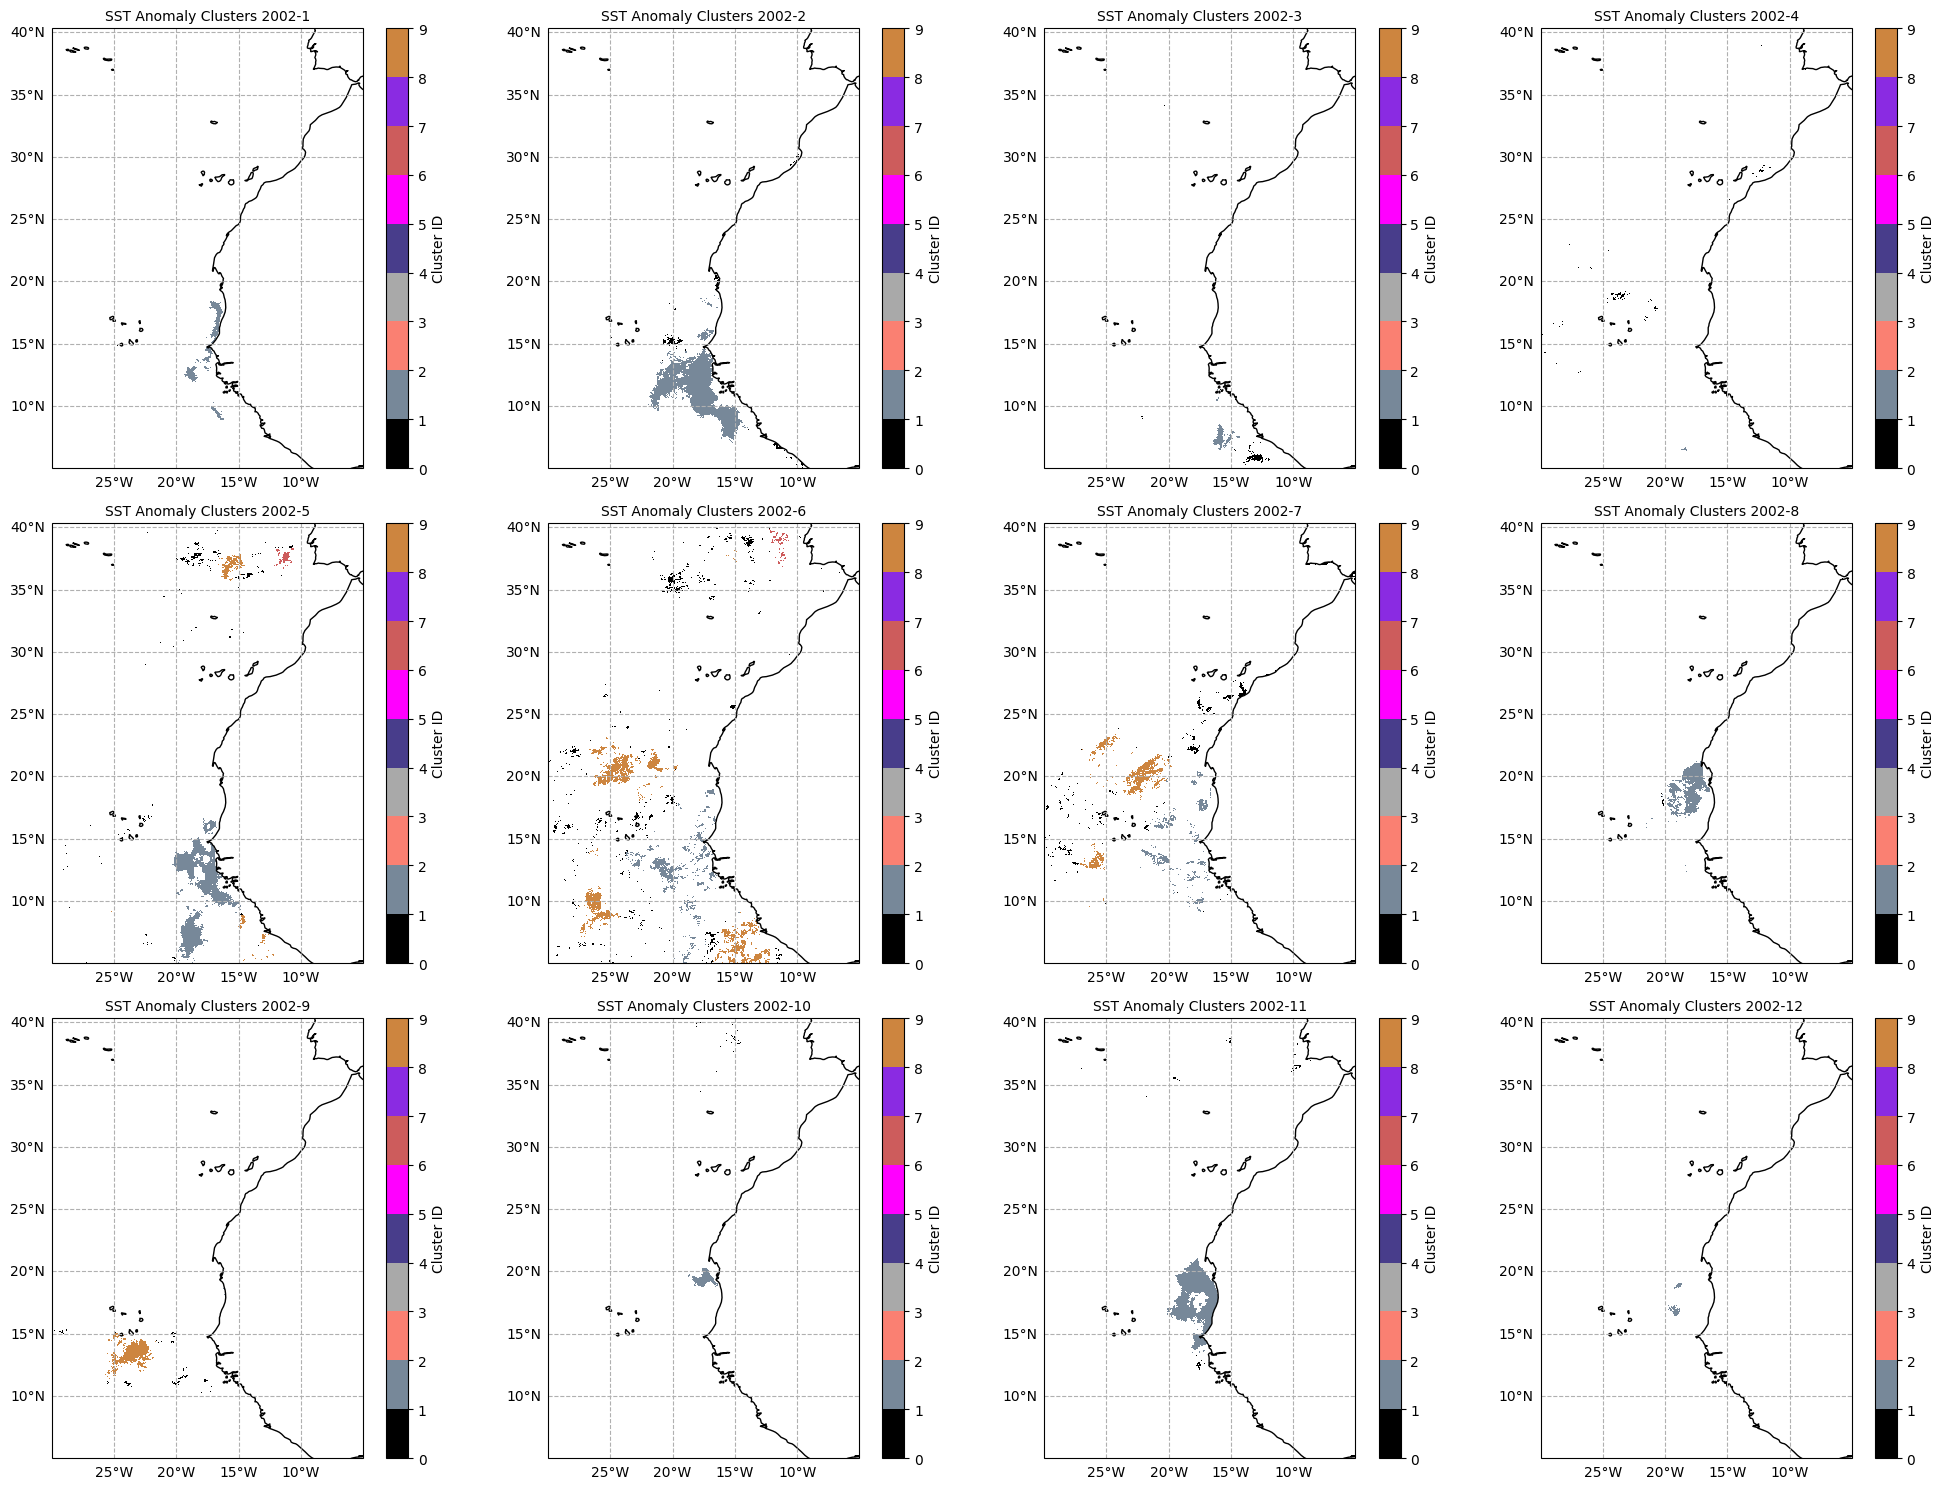

Experiment name: Smaller Geo Eps
Found: 12 | Discarded: 21 | Runtime: 55.83 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_1_5_5_100_1000.pkl


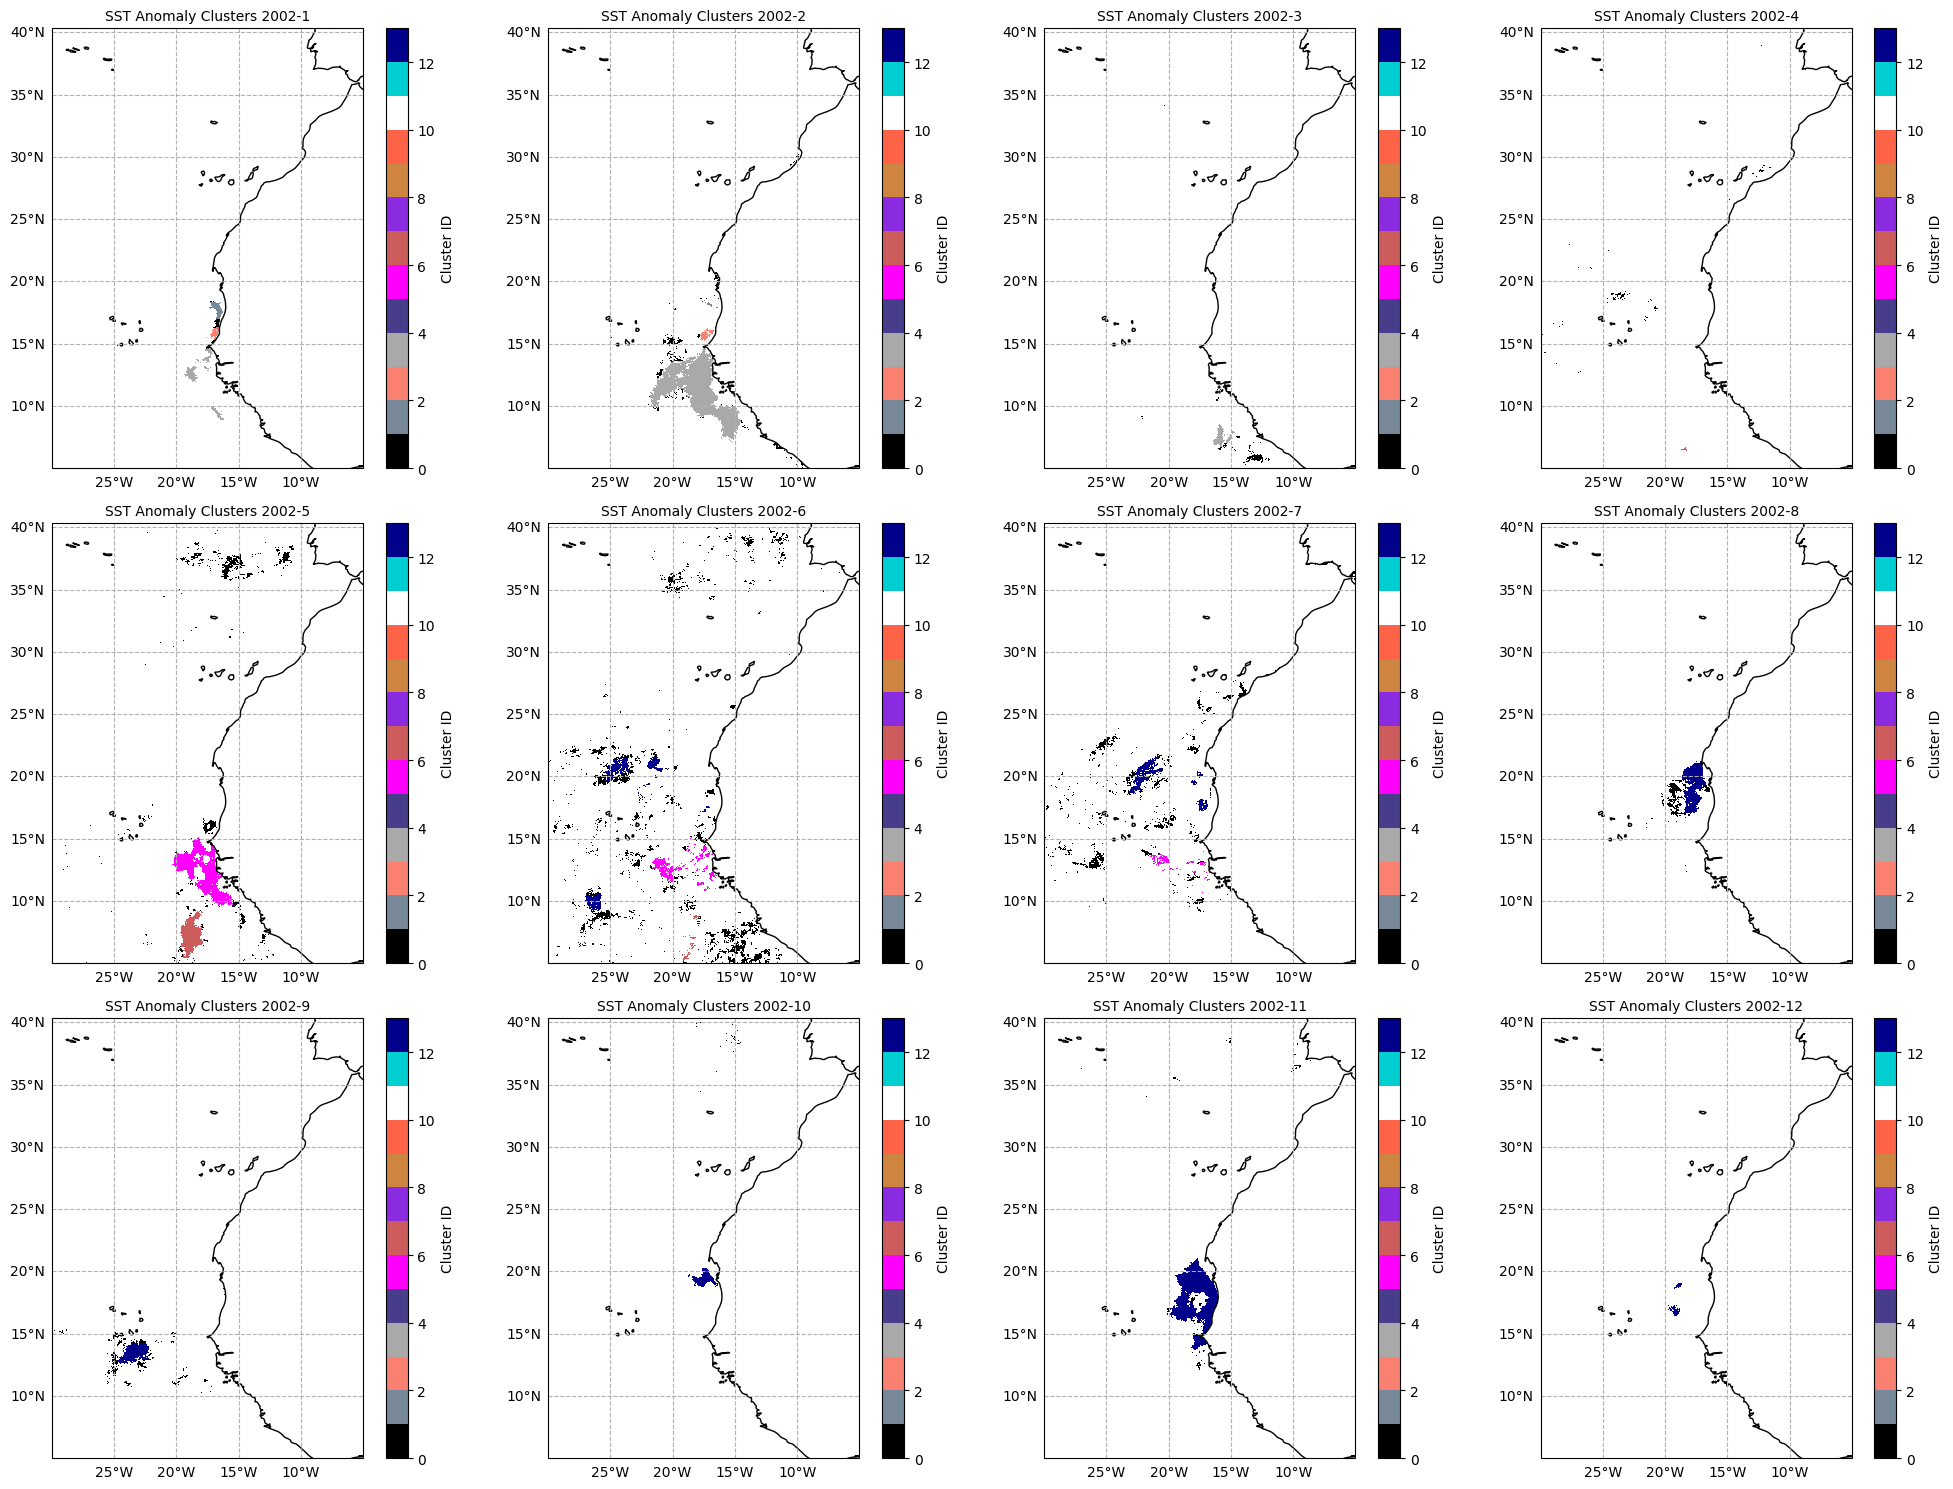

Experiment name: Larger Geo Eps
Found: 4 | Discarded: 4 | Runtime: 7206.46 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_1_20_20_100_1000.pkl


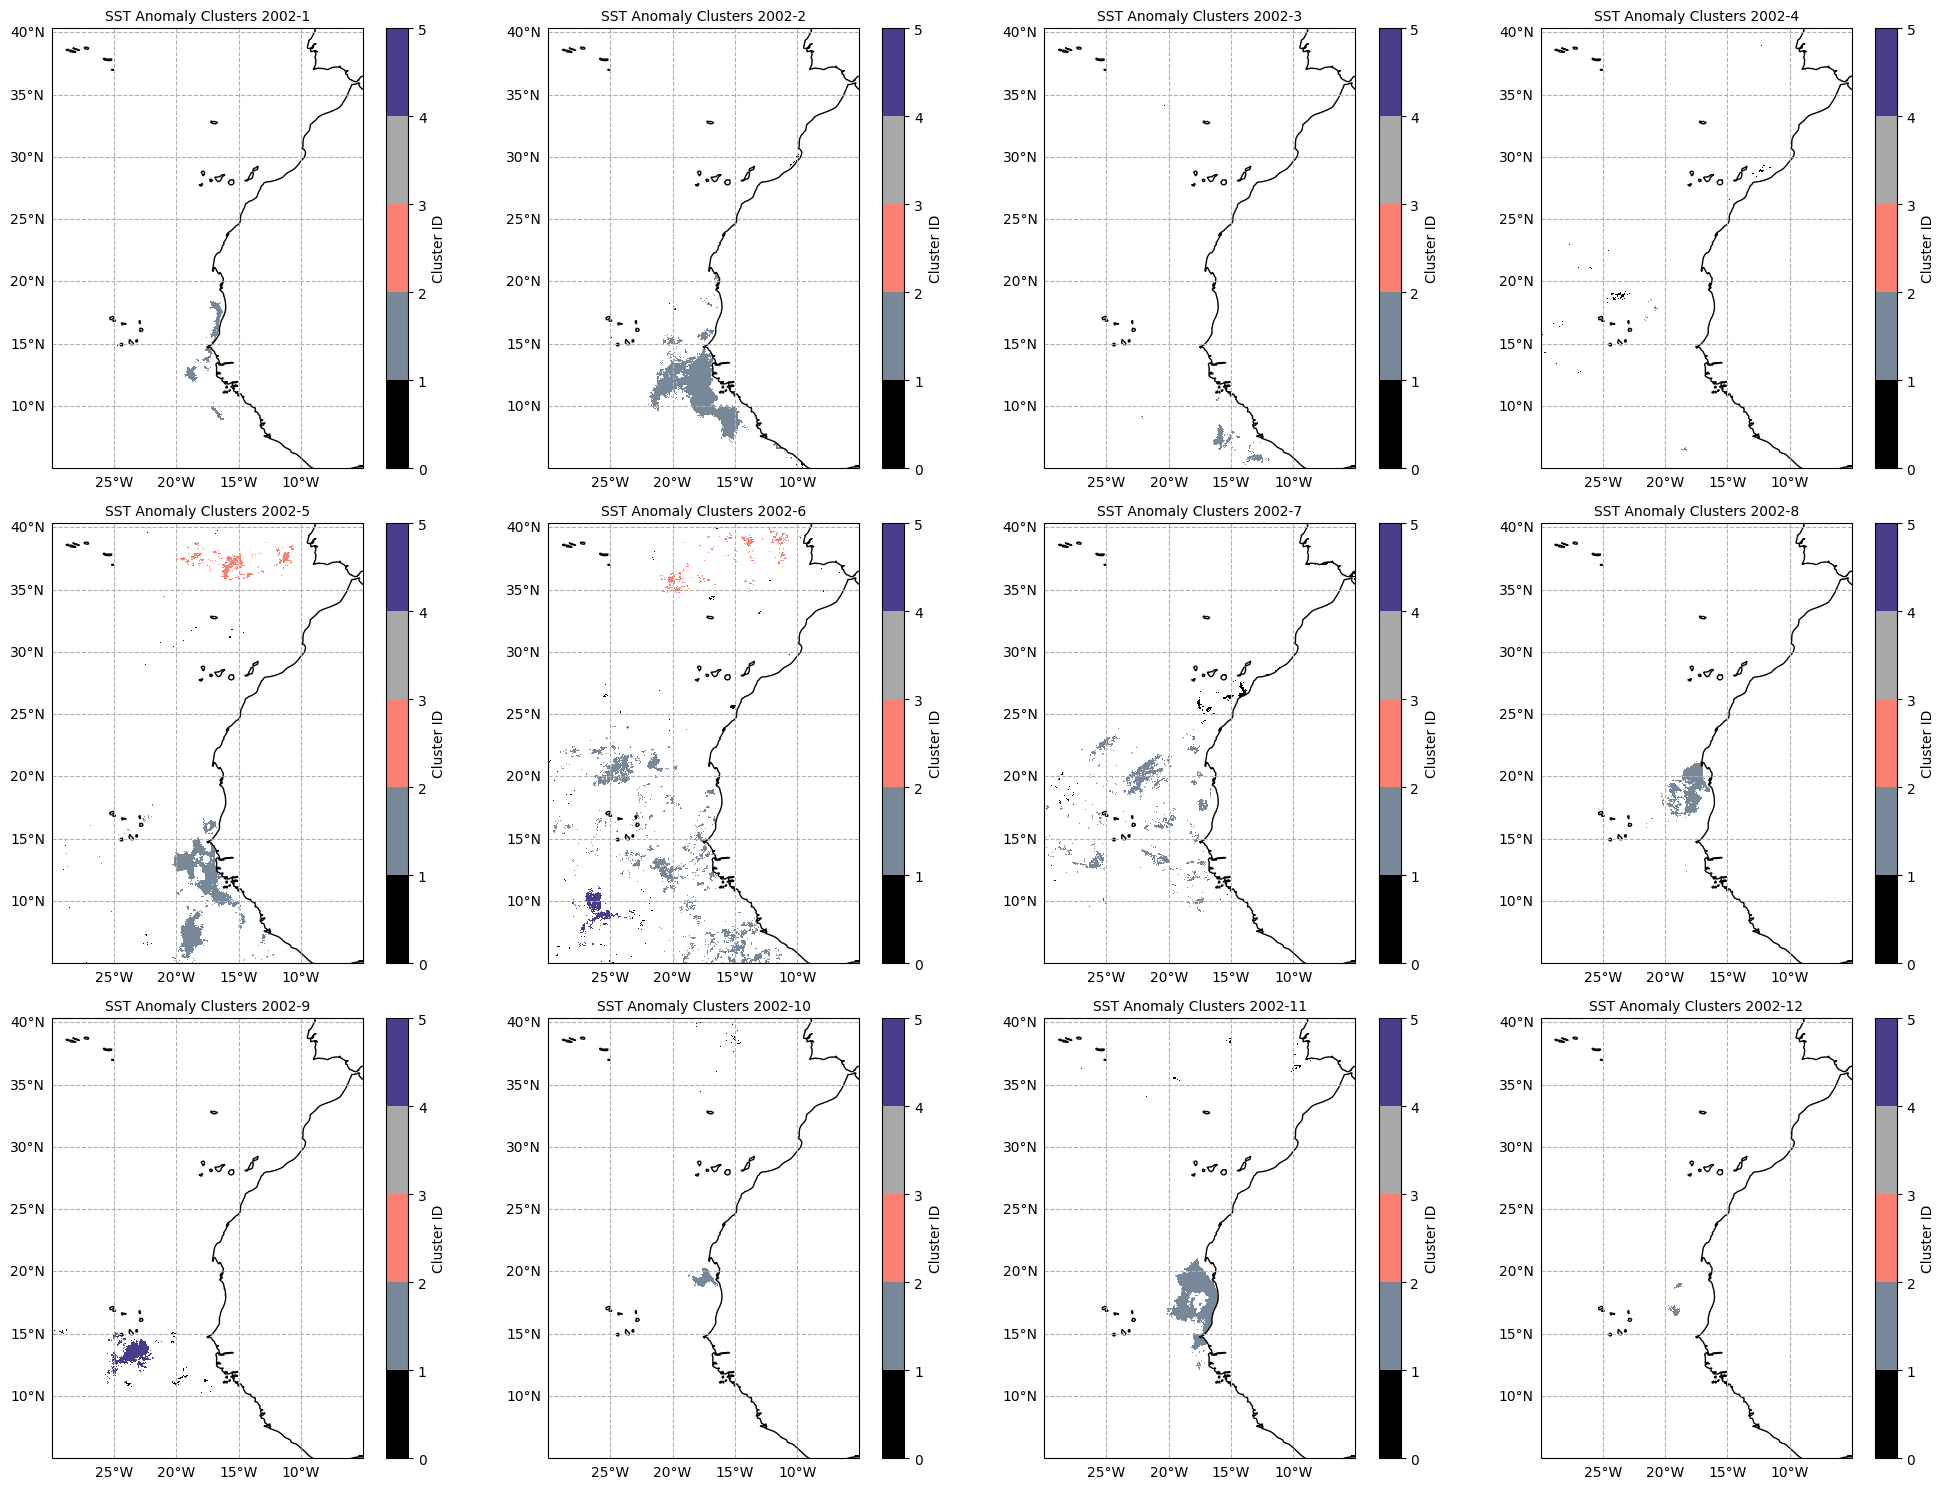

Experiment name: Larger Time Eps
Found: 5 | Discarded: 12 | Runtime: 990.43 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_2_10_10_100_1000.pkl


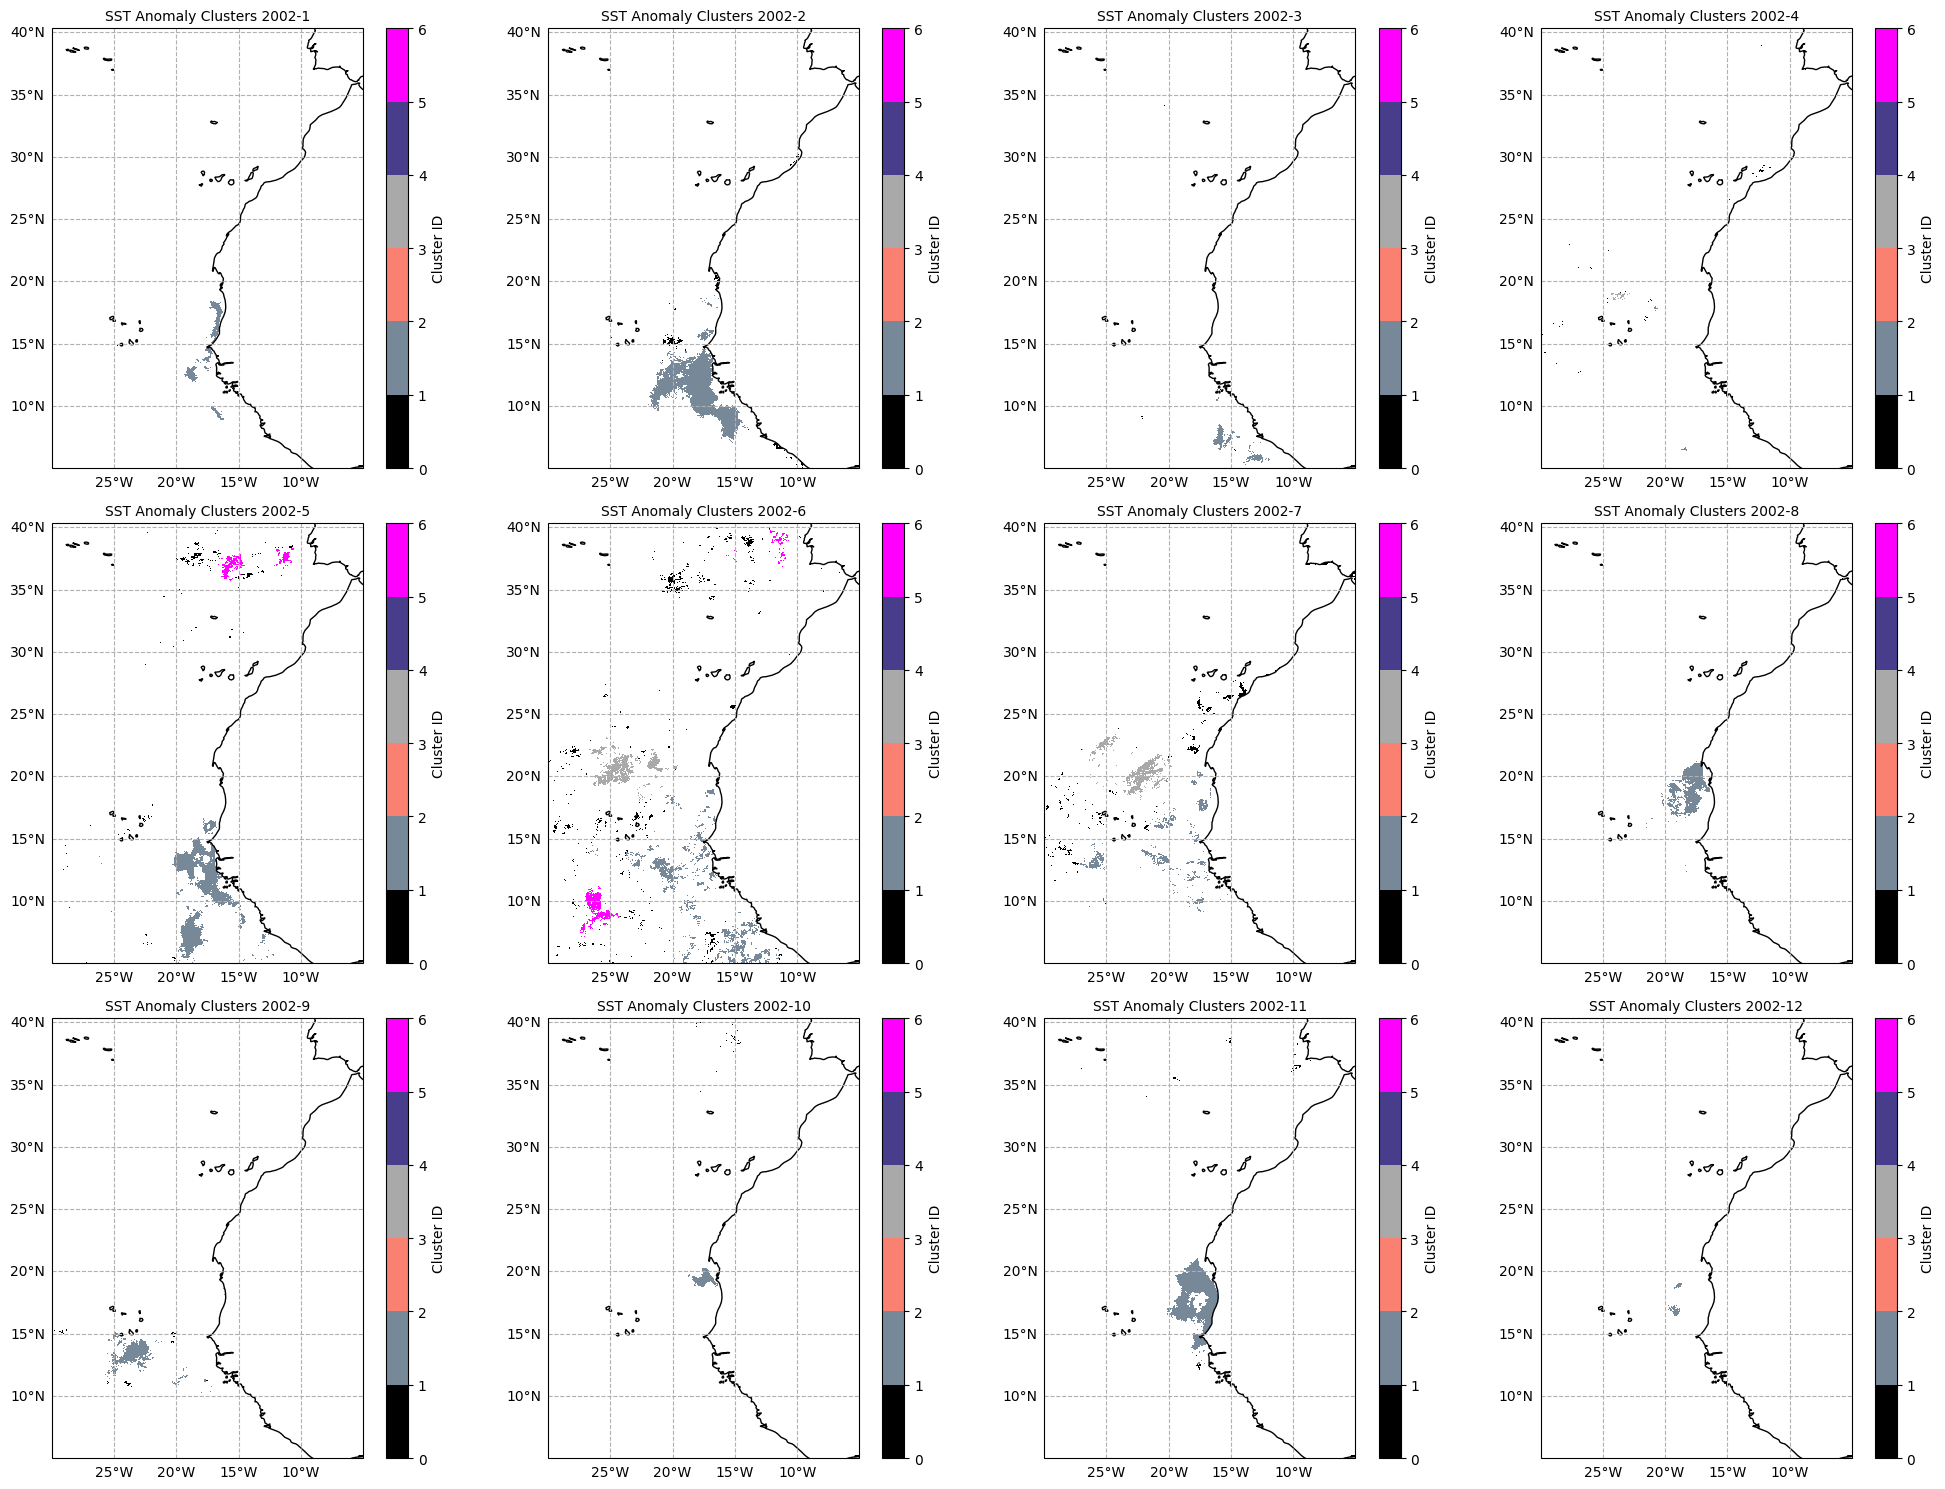

Experiment name: Much Larger Time Eps
Found: 5 | Discarded: 12 | Runtime: 1703.76 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_10_10_10_100_1000.pkl


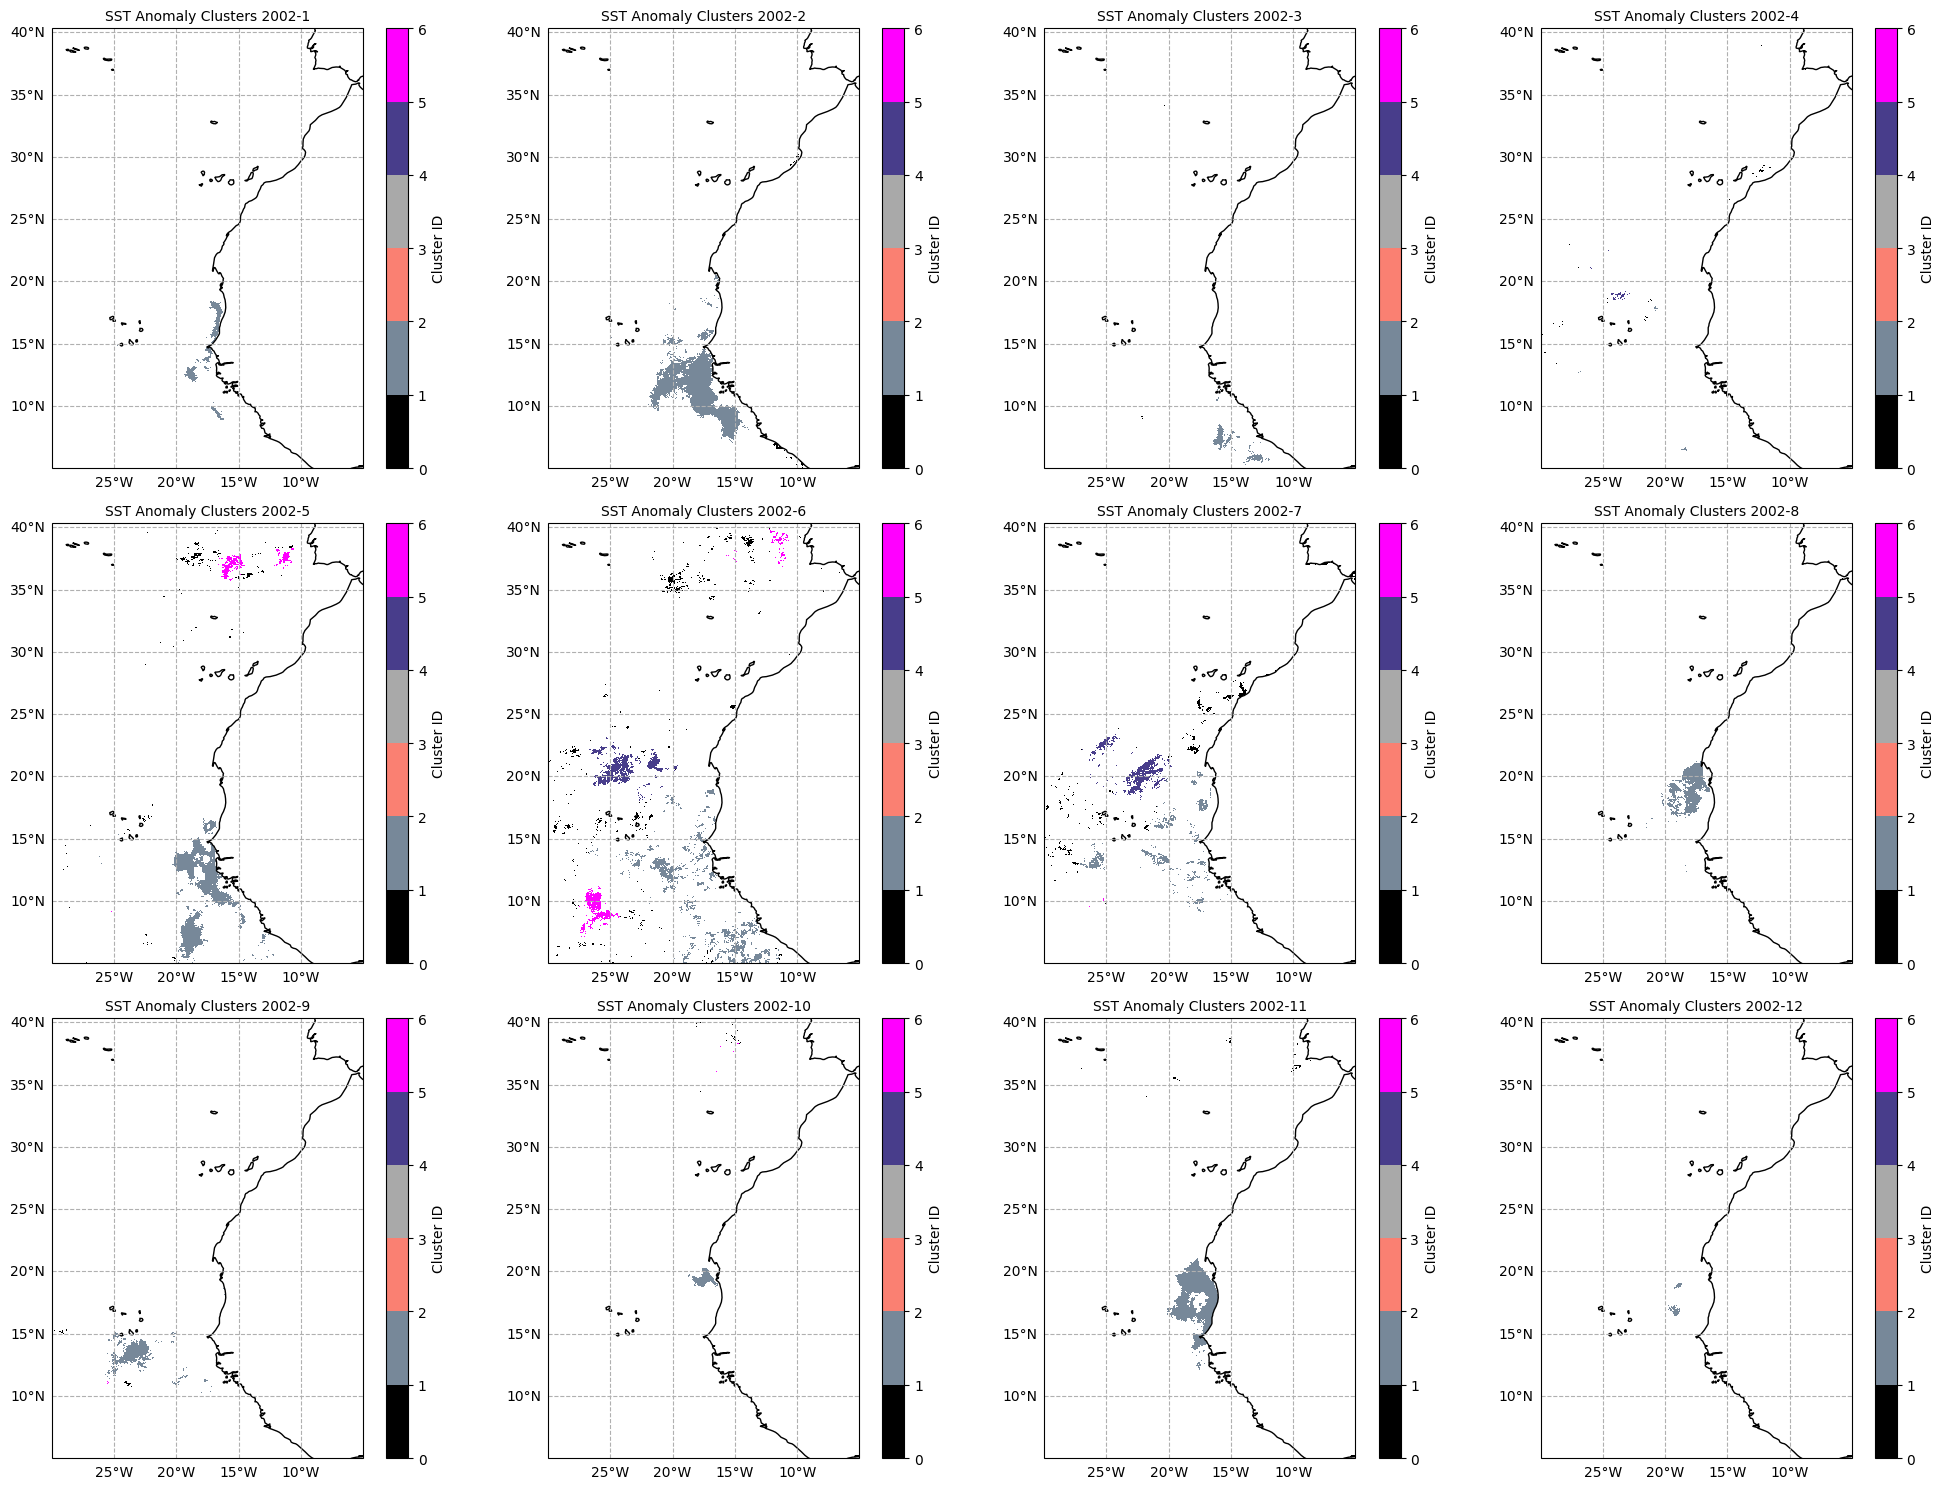

Experiment name: Smaller MinNeighbors
Found: 8 | Discarded: 23 | Runtime: 557.77 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_1_10_10_50_1000.pkl


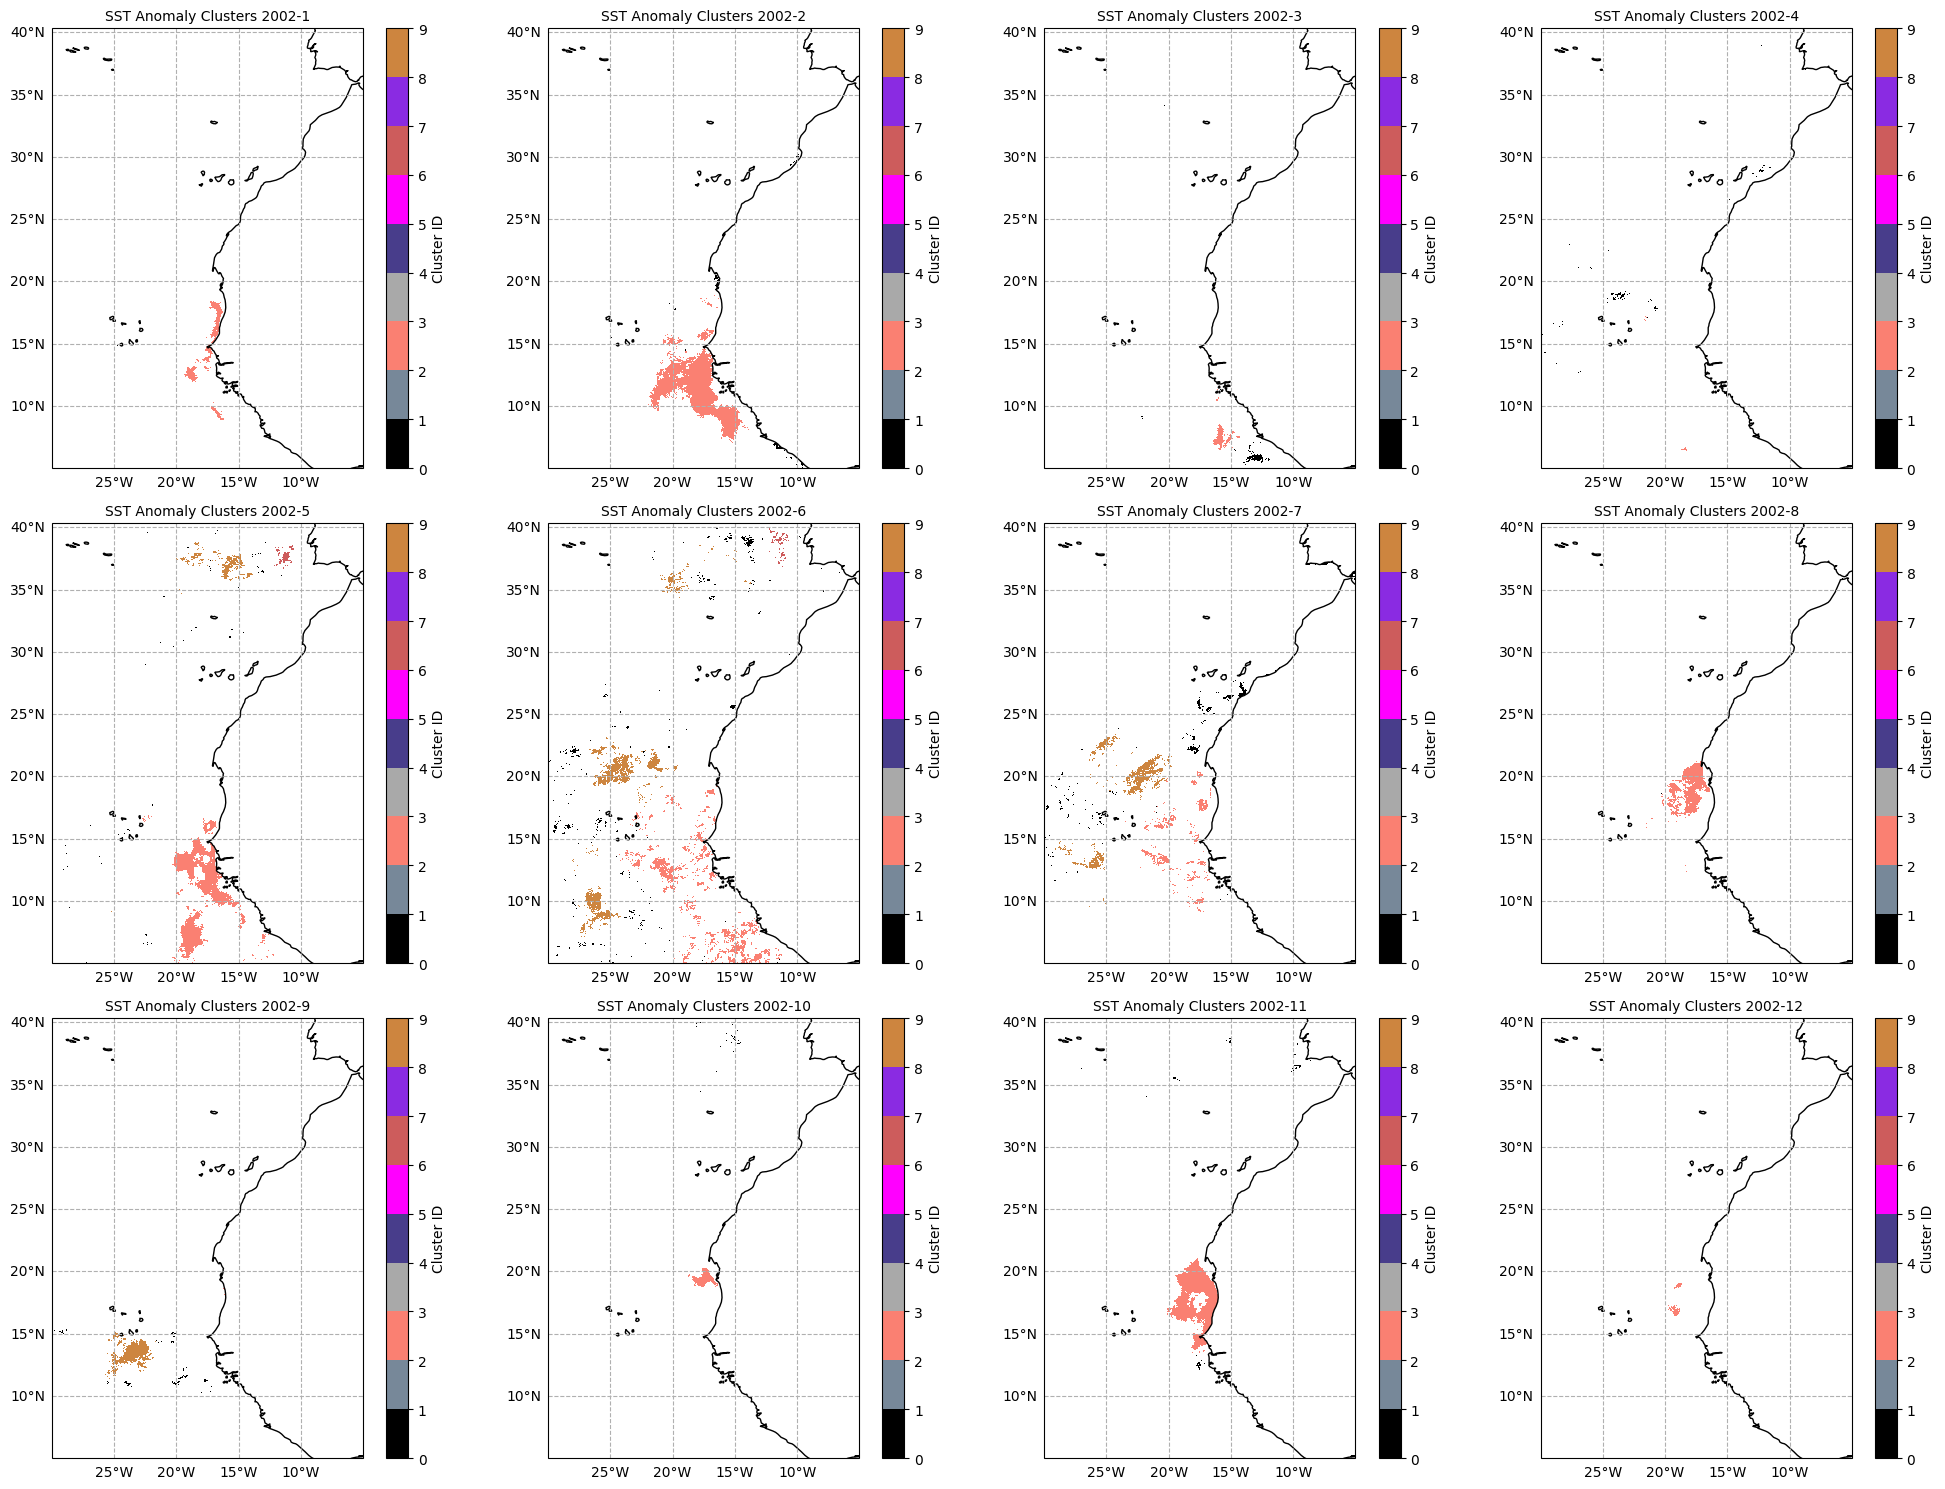

Experiment name: Larger MinNeighbors
Found: 15 | Discarded: 3 | Runtime: 368.00 seconds
File name: clustering_experiment_2018-01-01_2018-12-01_sst_2_1_10_10_200_1000.pkl


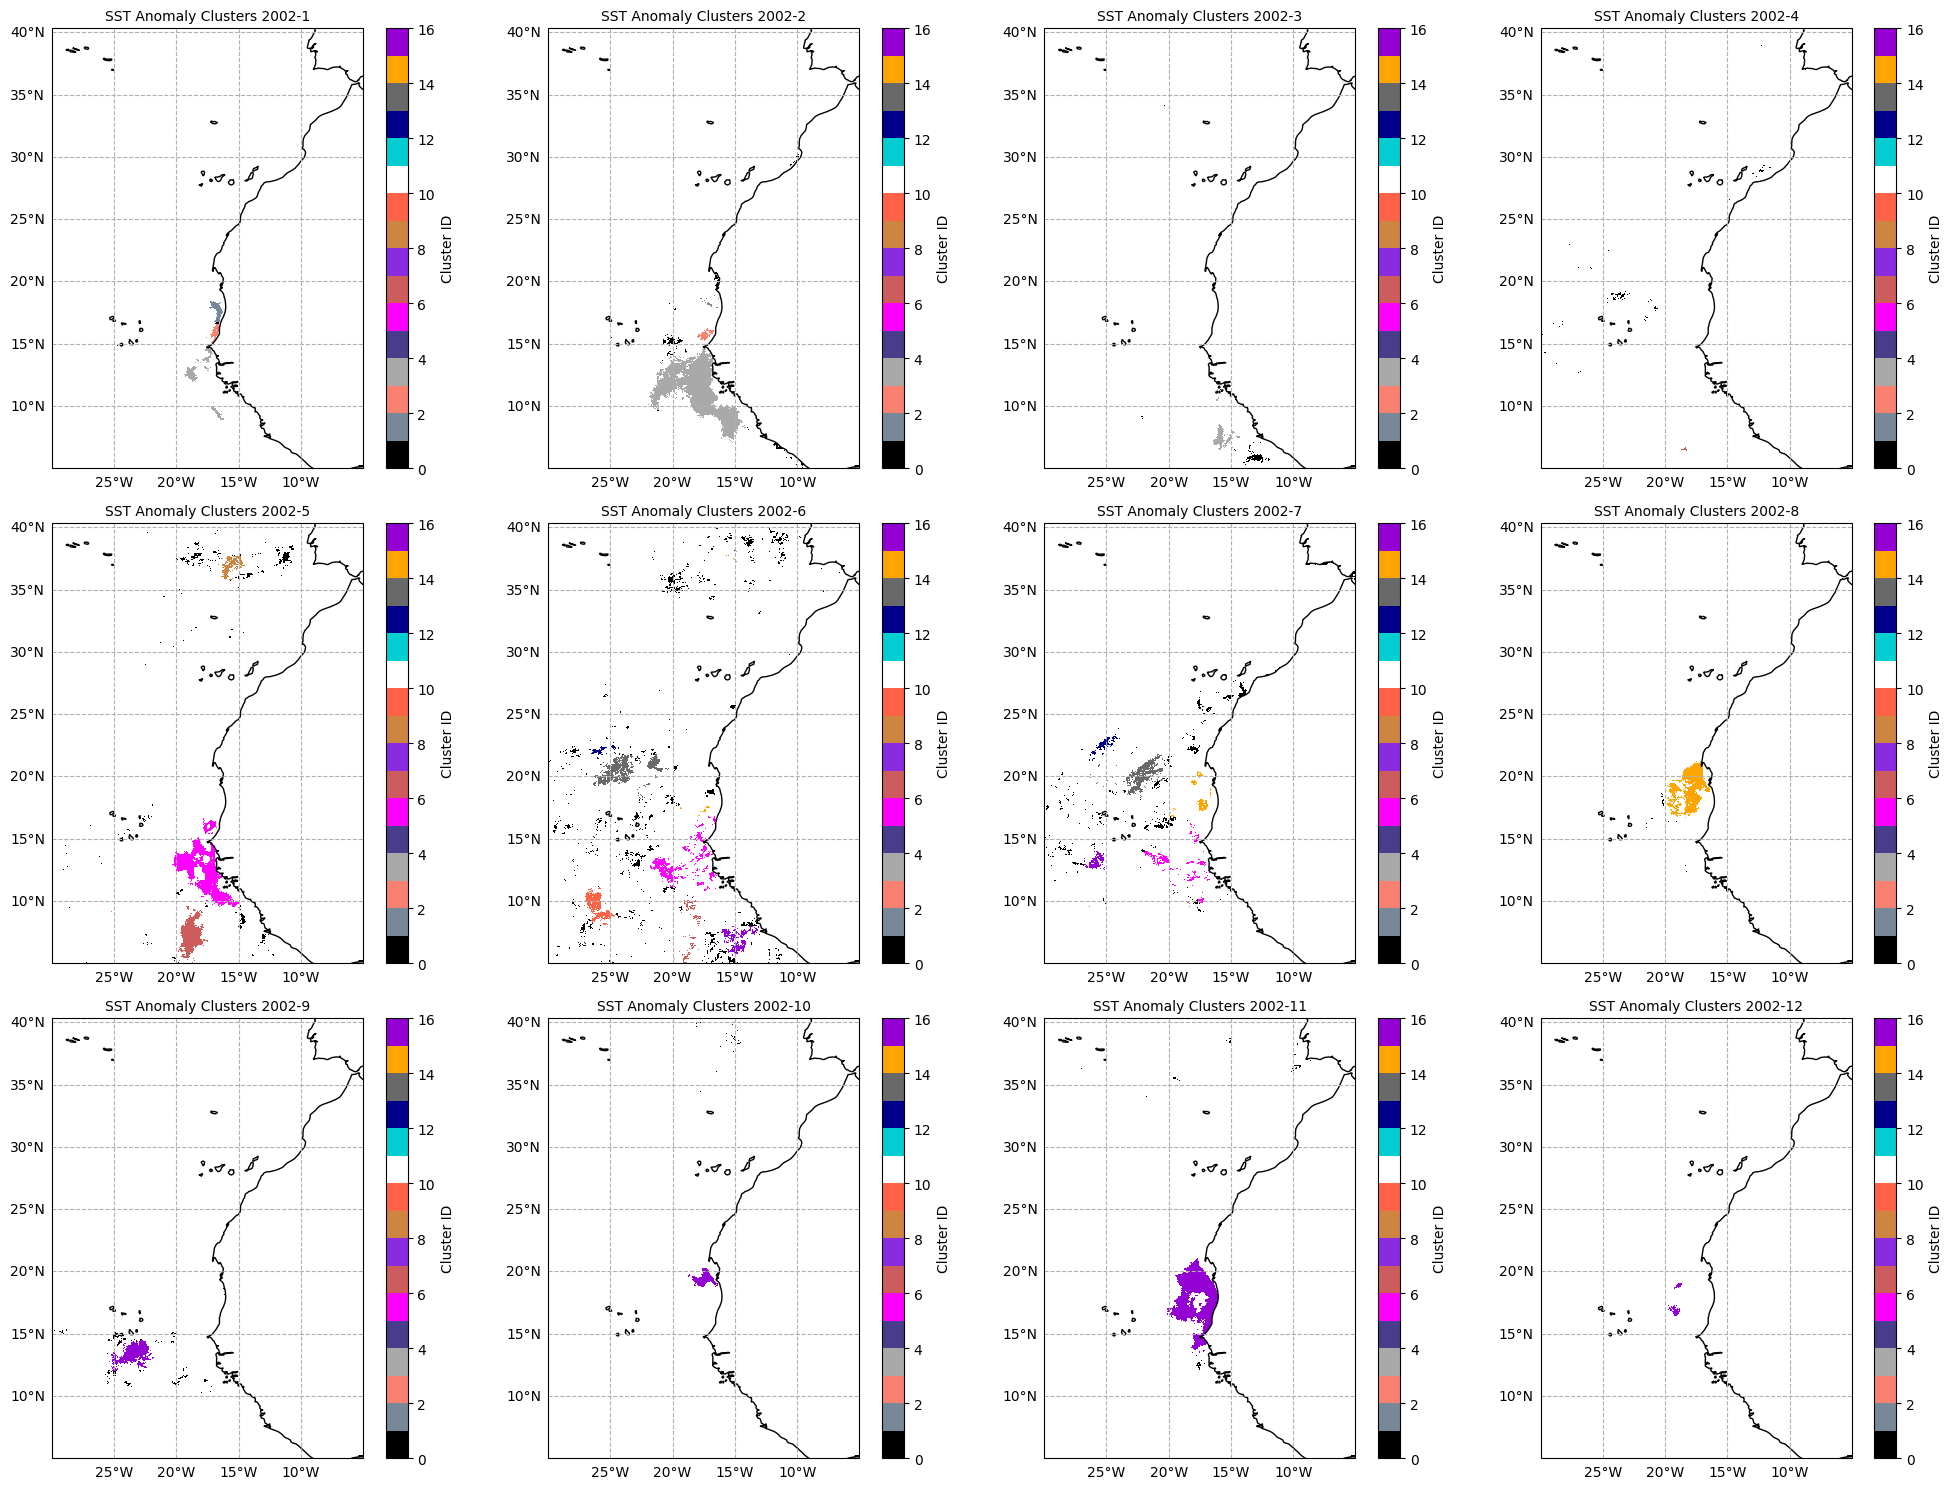

Experiment name: Base Full Period
Found: 67 | Discarded: 122 | Runtime: 2935.58 seconds
File name: clustering_experiment_2002-08-01_2024-07-01_sst_2_1_10_10_100_1000.pkl


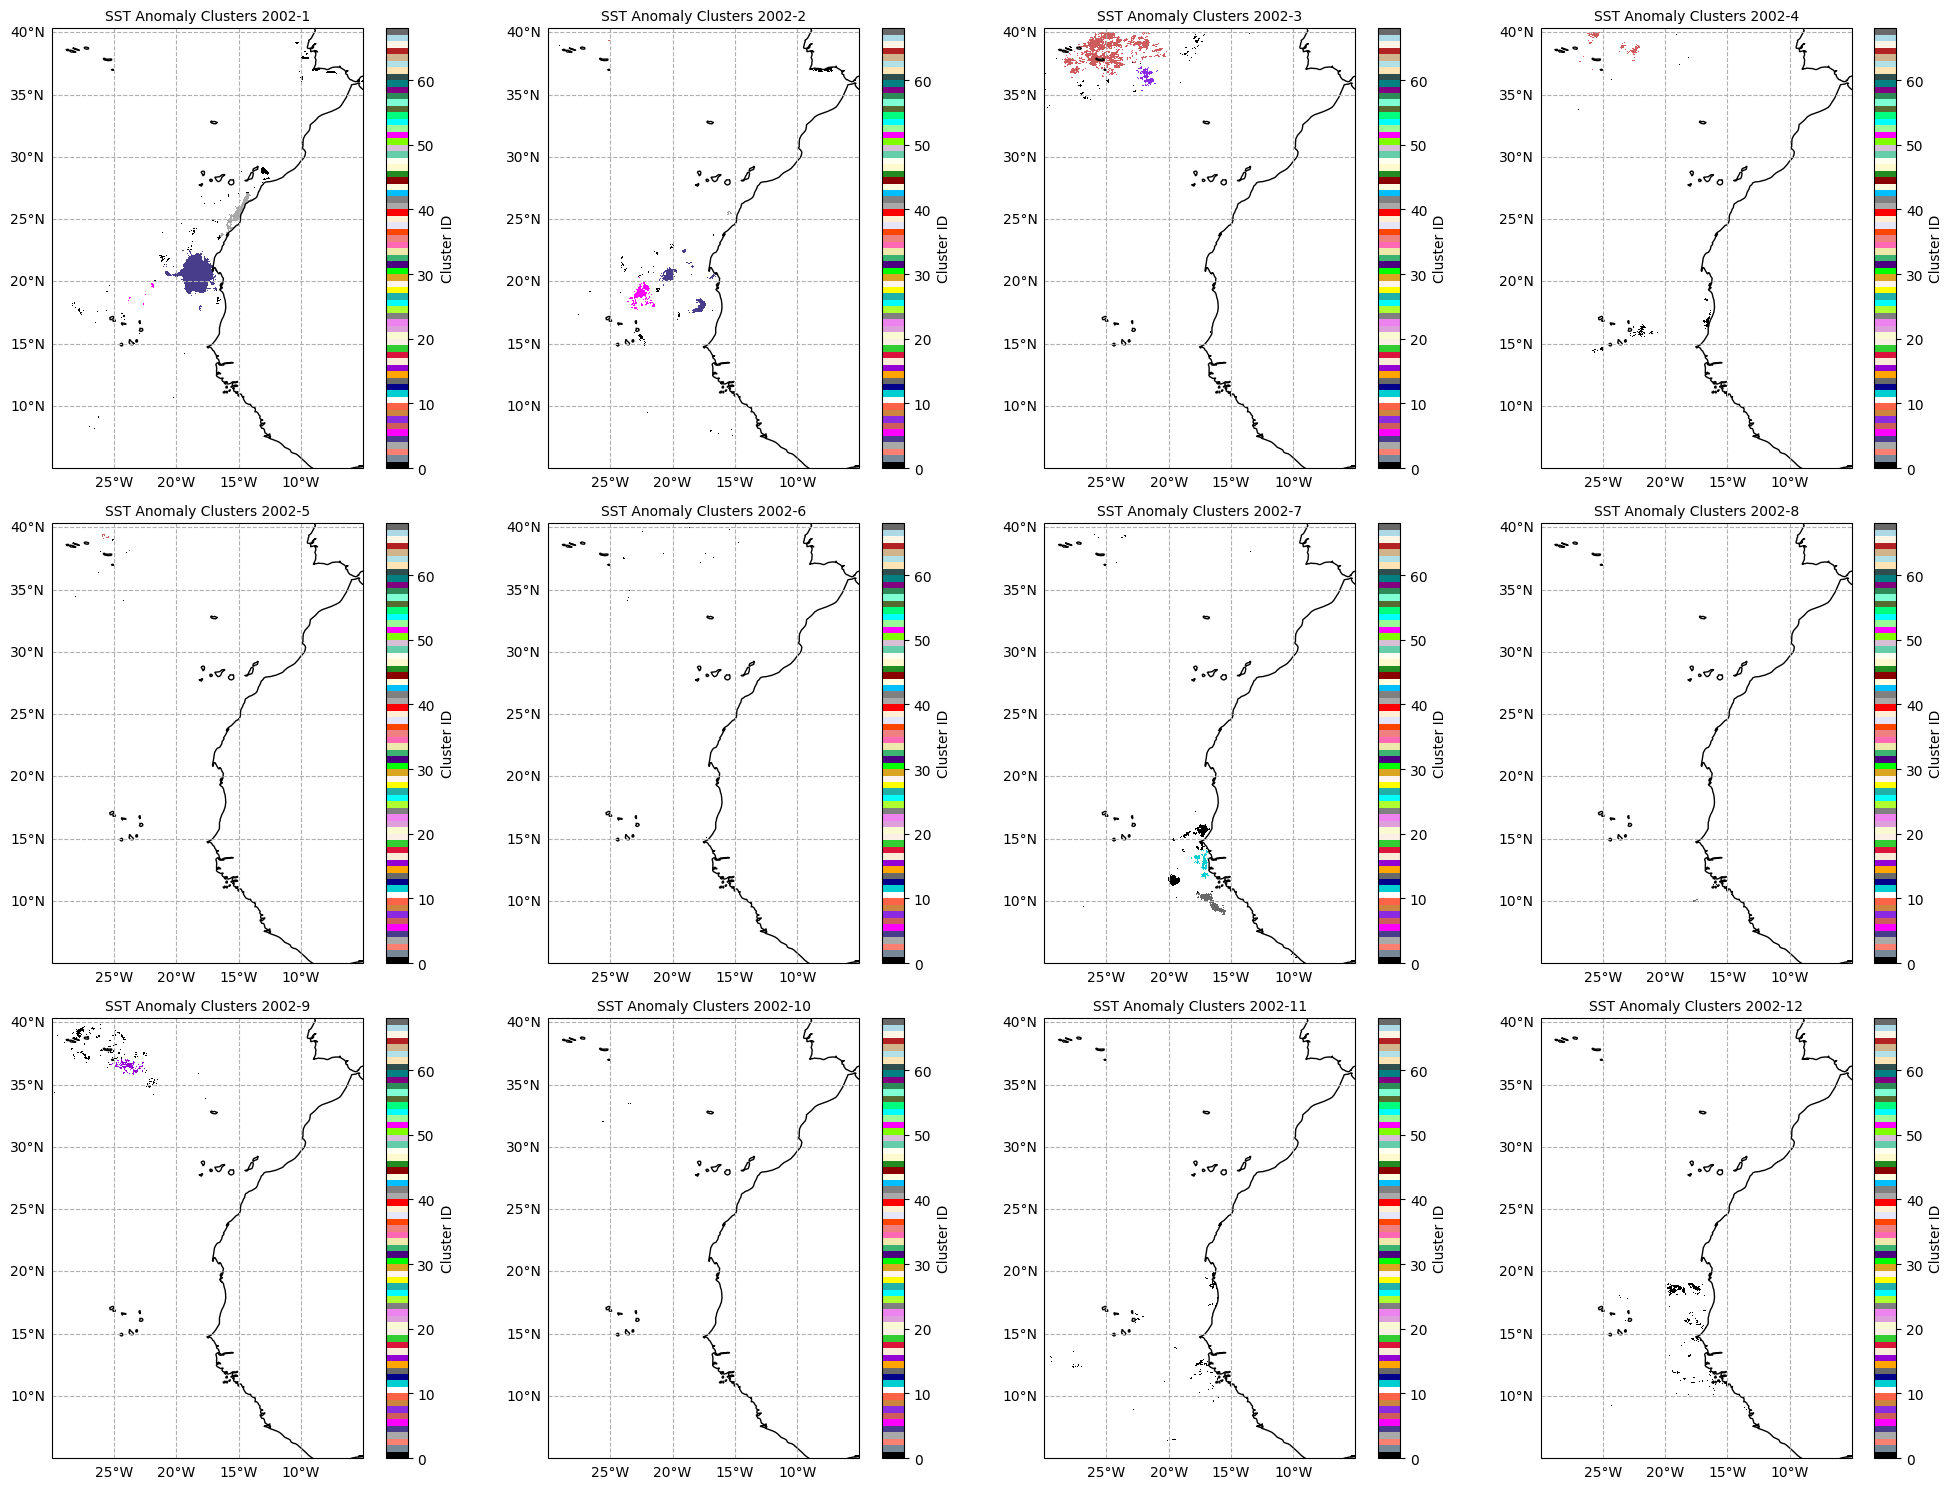

Experiment name: Larger Min Neighbors
Found: 51 | Discarded: 5 | Runtime: 14098.44 seconds
File name: clustering_experiment_2002-08-01_2024-07-01_sst_2_1_20_20_500_1000.pkl


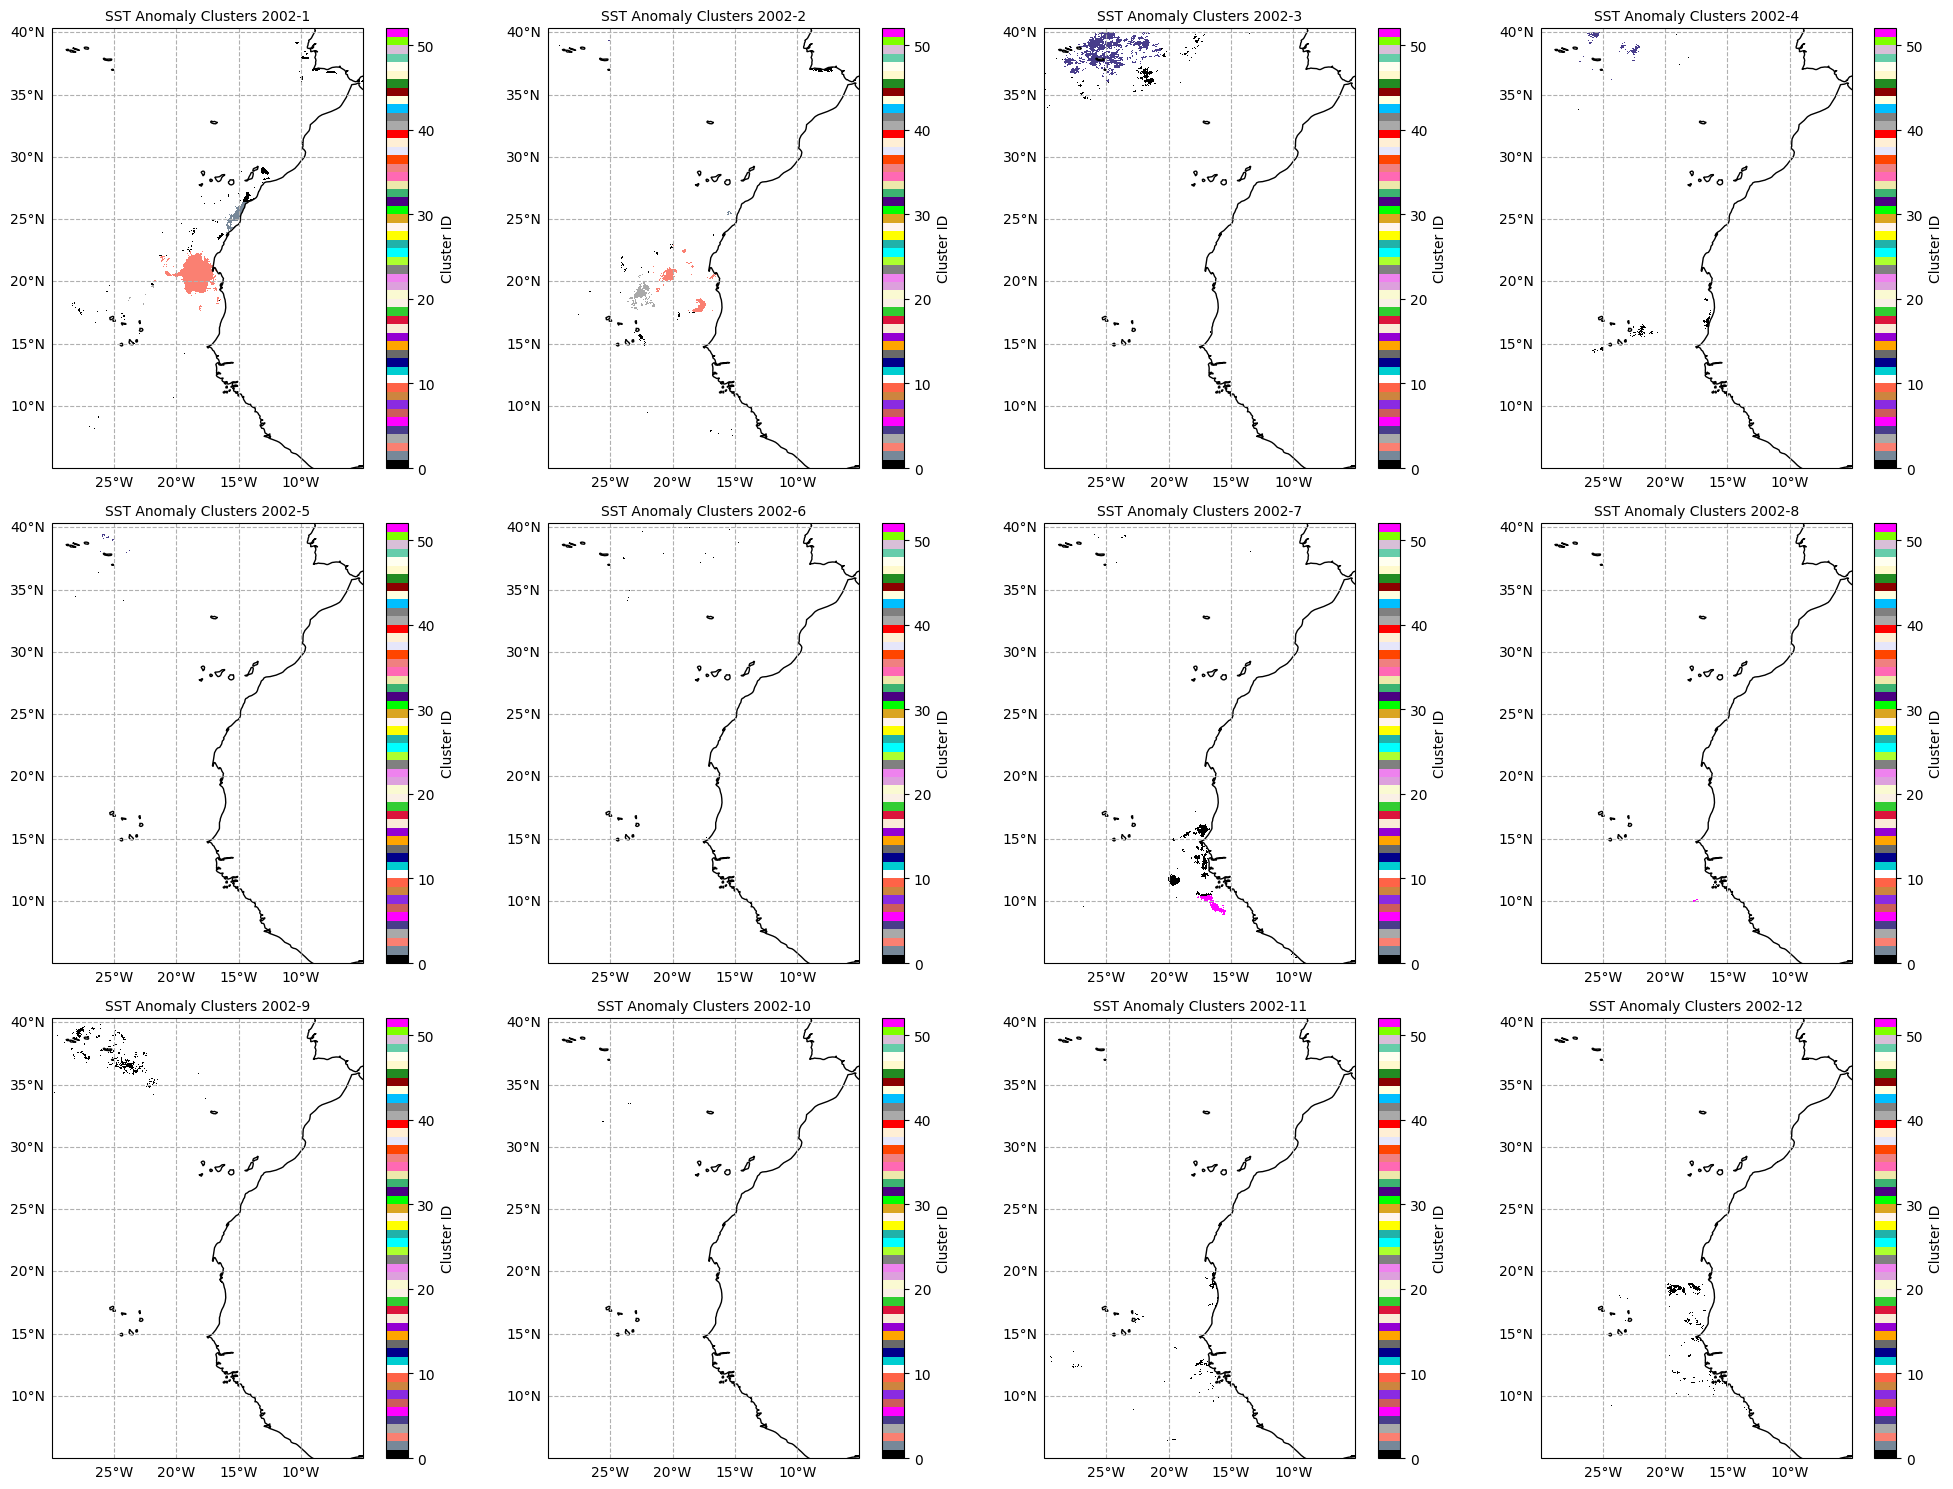

Experiment name: Much Larger Min Neighbors
Found: 25 | Discarded: 0 | Runtime: 12041.89 seconds
File name: clustering_experiment_2002-08-01_2024-07-01_sst_2_1_20_20_1000_1000.pkl


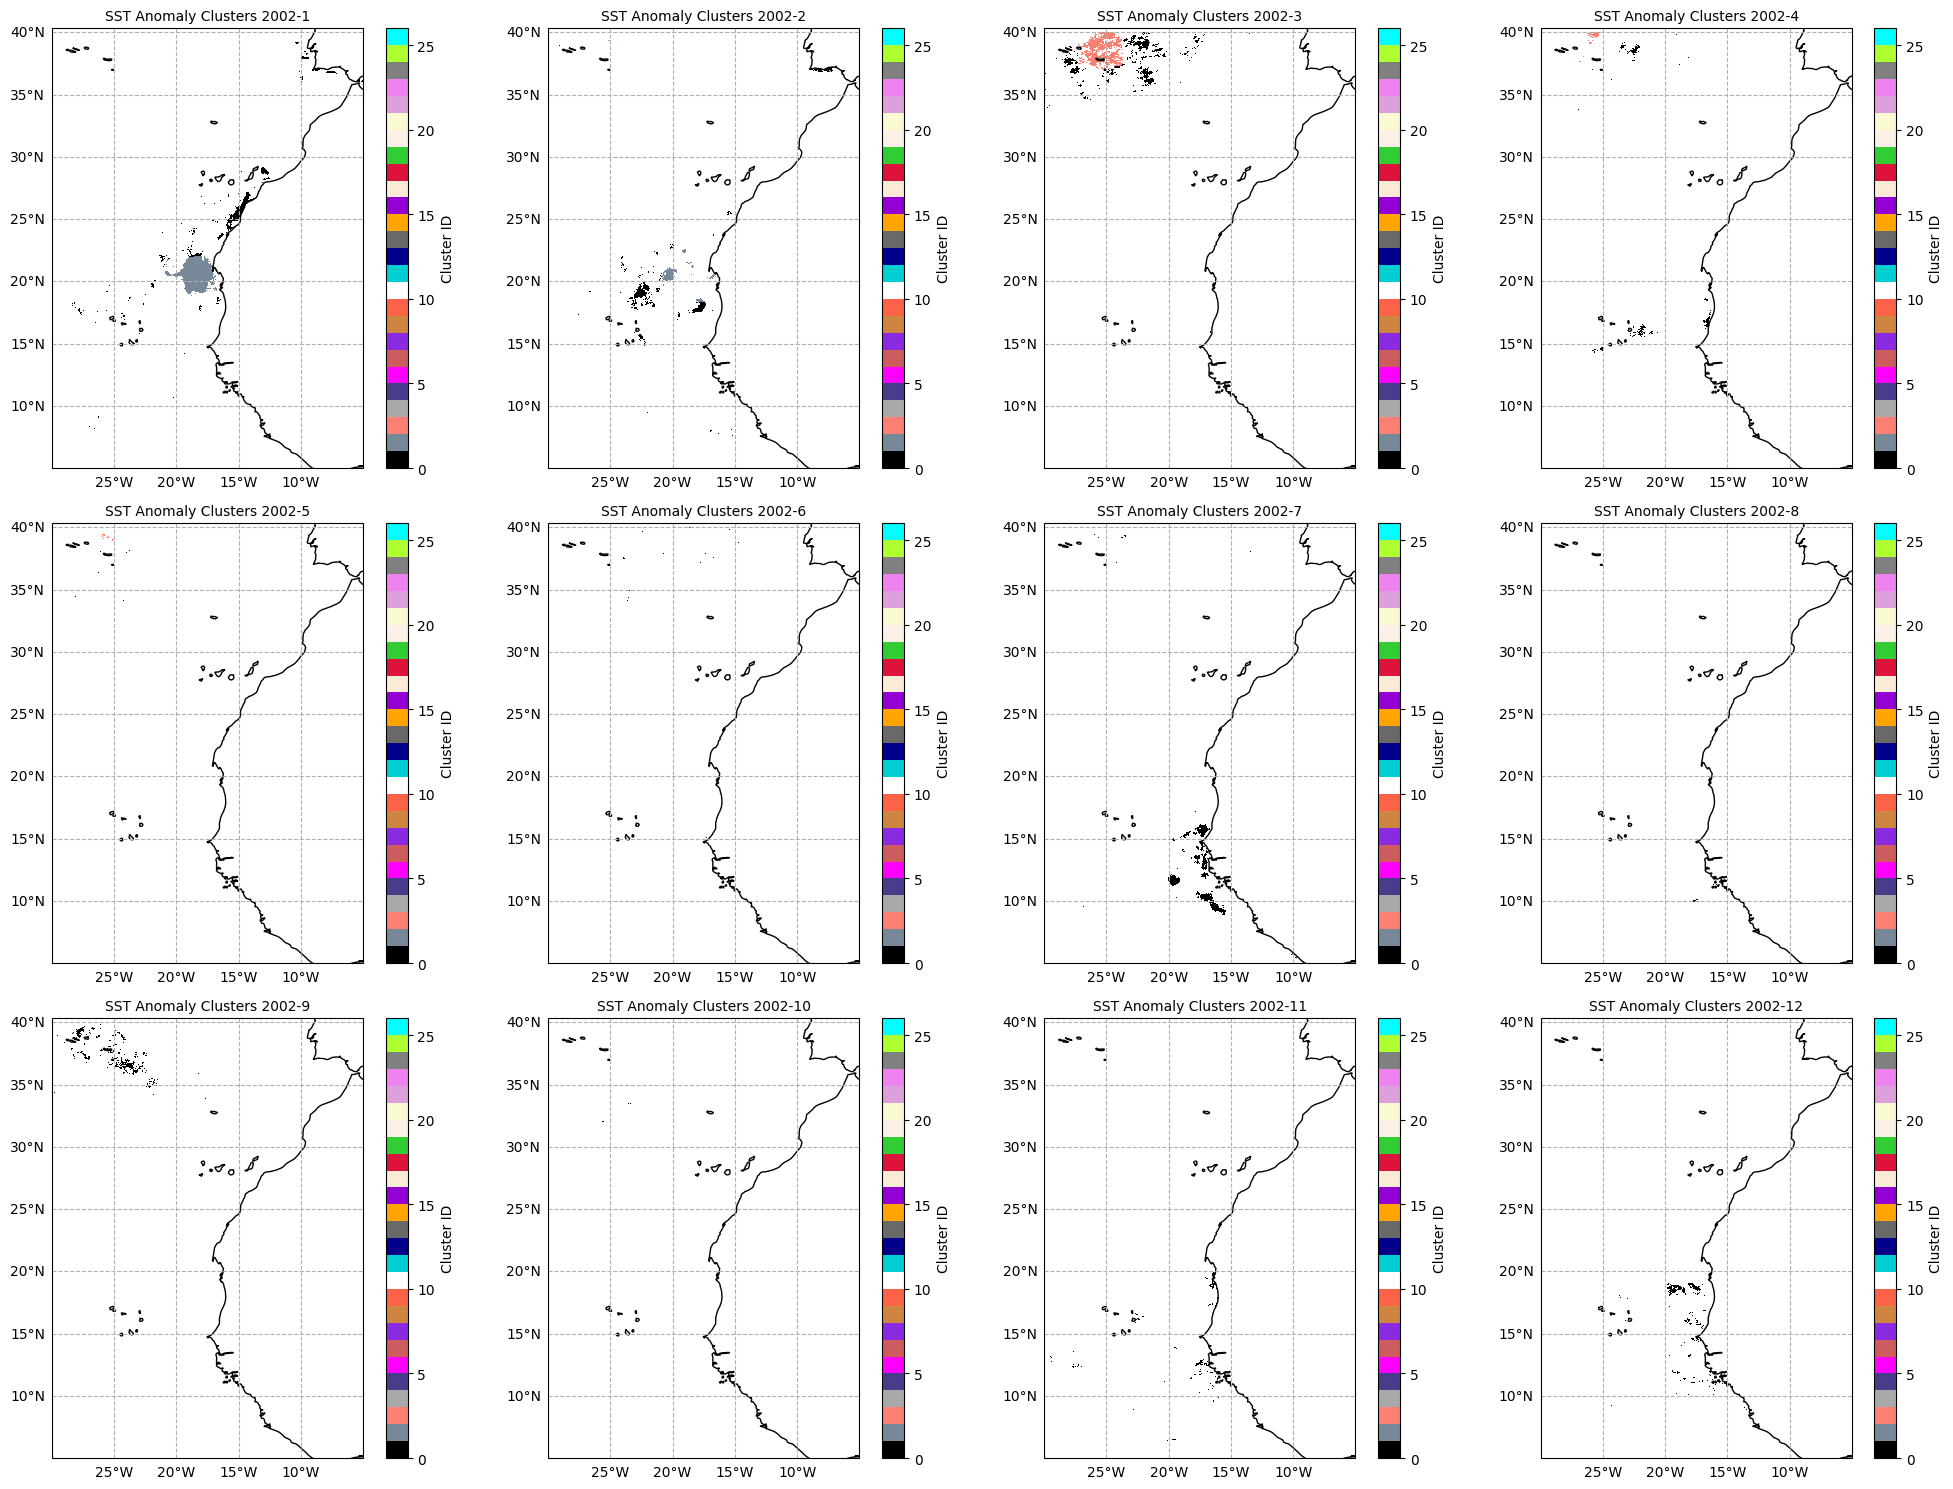

Experiment name: Smaller Geo Eps
Found: 27 | Discarded: 3 | Runtime: 1299.42 seconds
File name: clustering_experiment_2002-08-01_2024-07-01_sst_2_1_10_10_500_1000.pkl


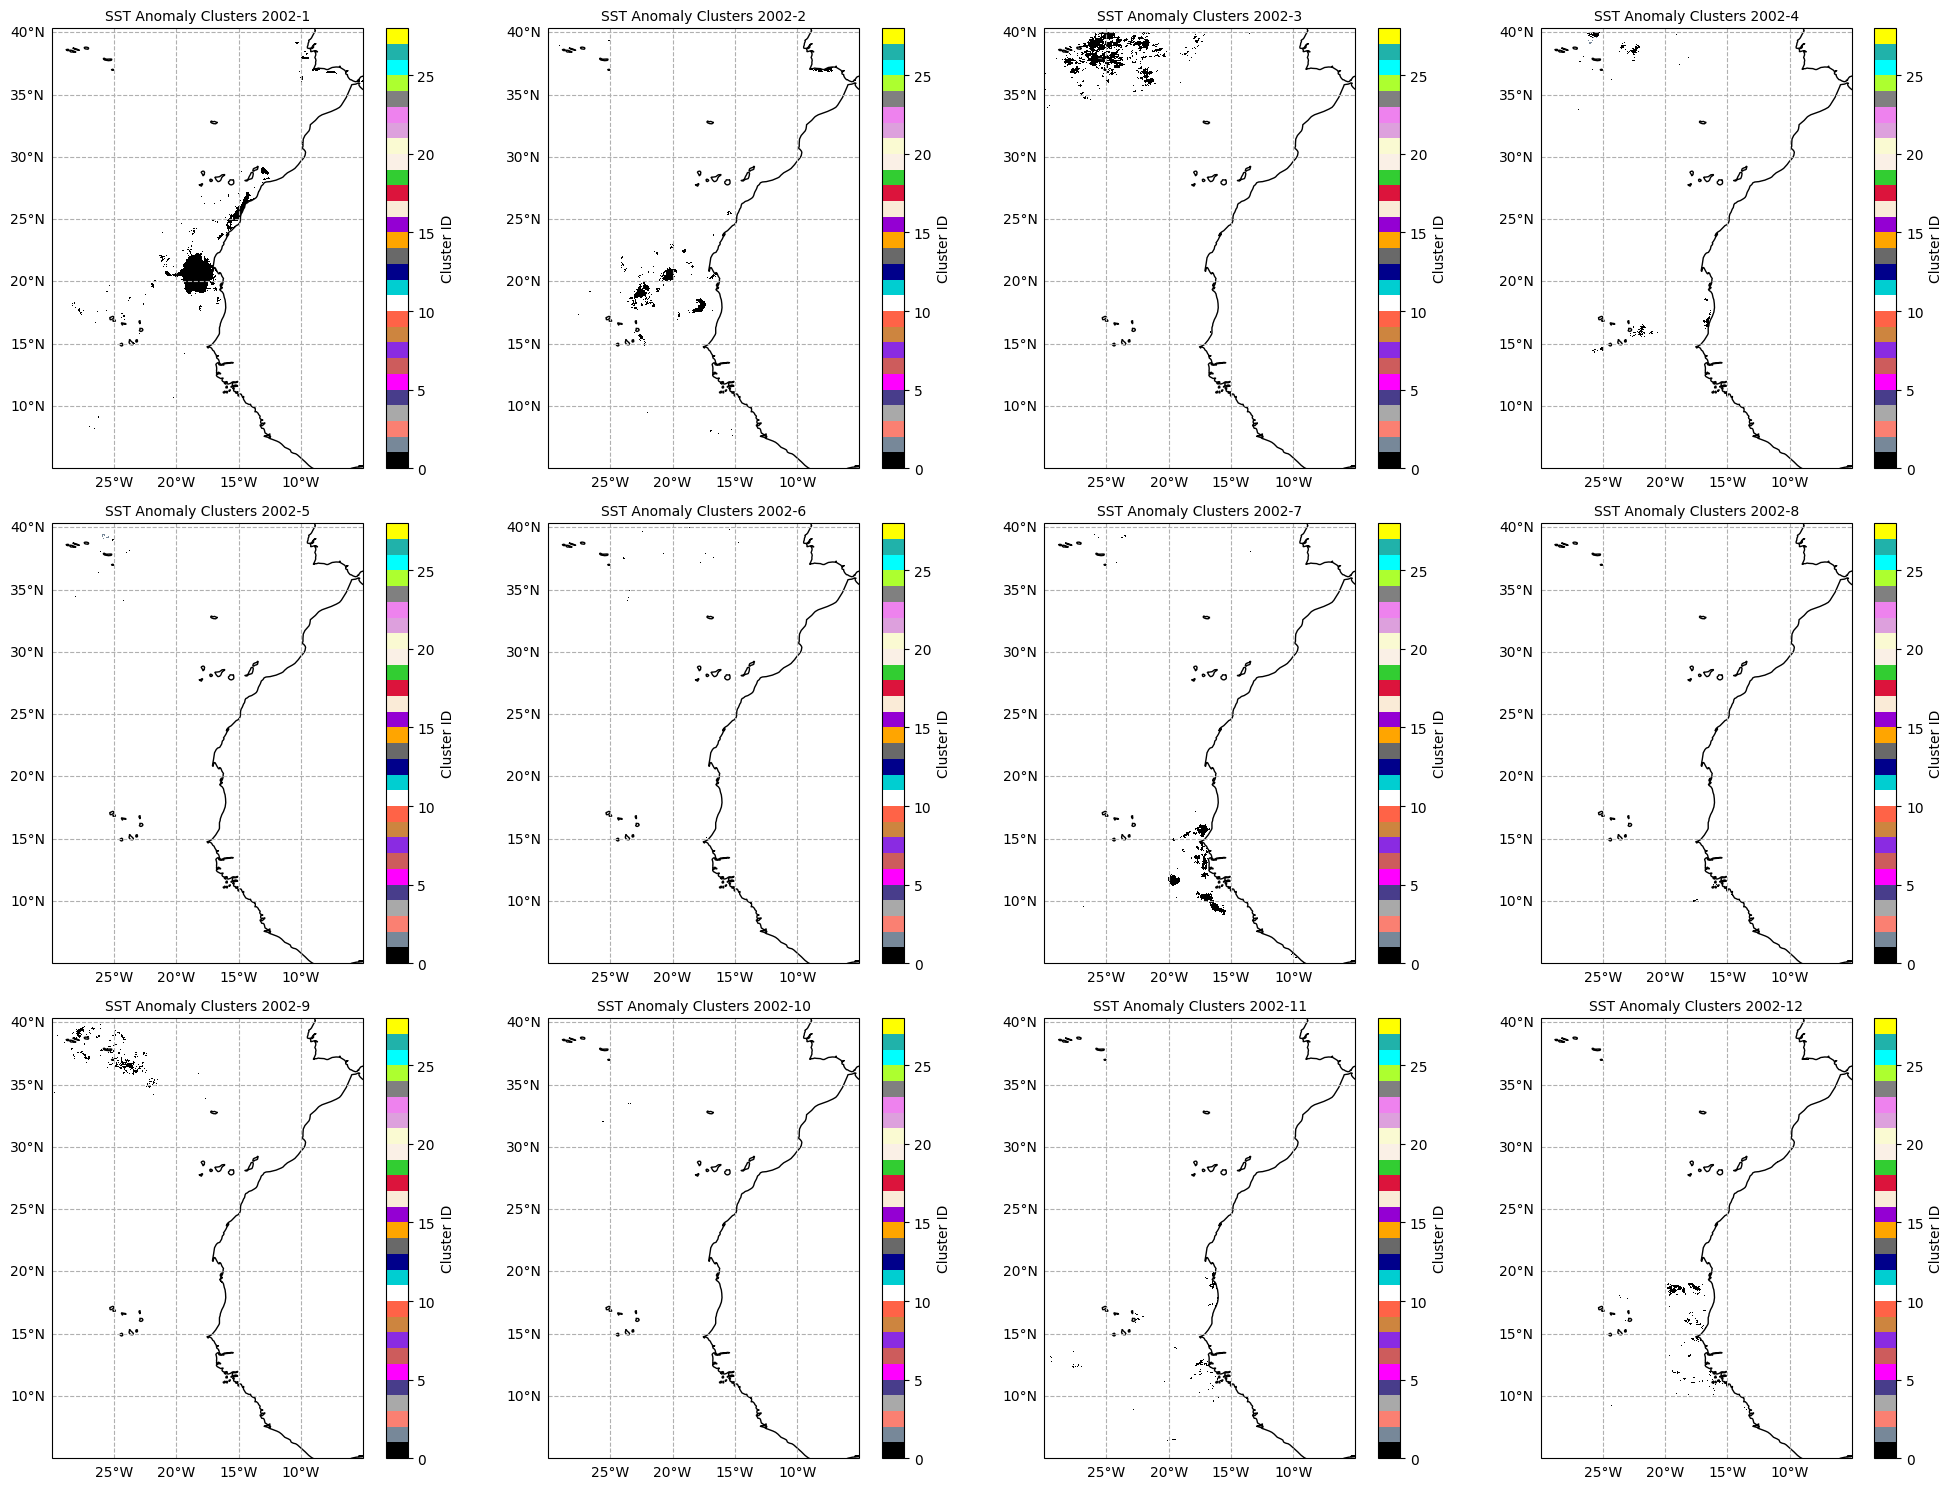

Experiment name: Larger Time Eps
Found: 46 | Discarded: 6 | Runtime: 25272.36 seconds
File name: clustering_experiment_2002-08-01_2024-07-01_sst_2_2_20_20_500_1000.pkl


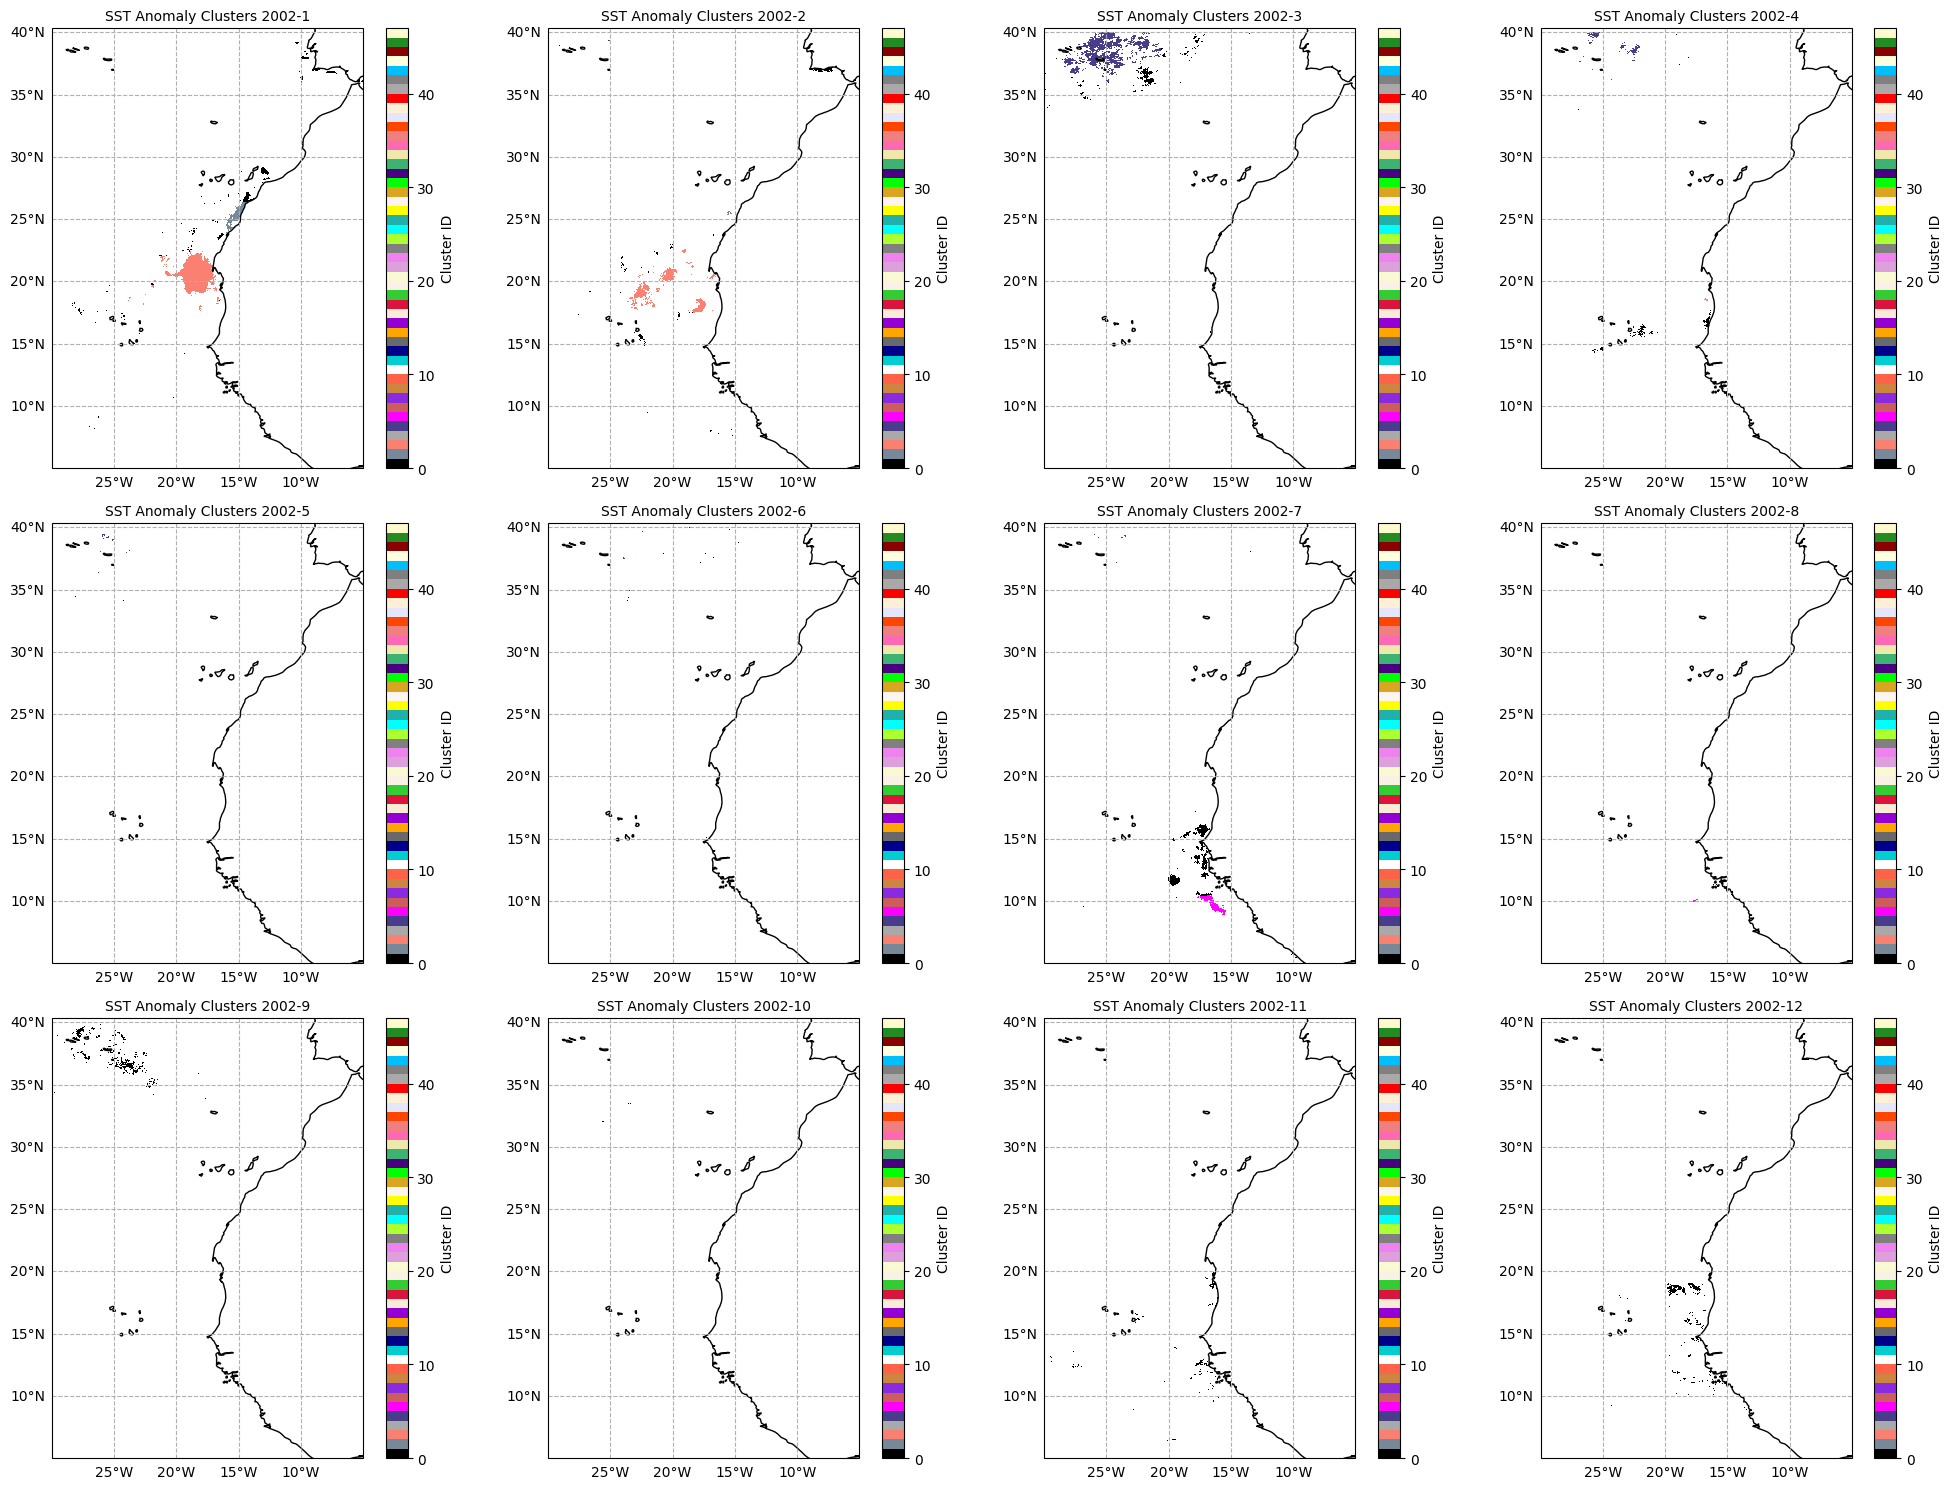

Experiment name: Much Larger Time Eps
Found: 31 | Discarded: 1 | Runtime: 53839.56 seconds
File name: clustering_experiment_2002-08-01_2024-07-01_sst_2_12_20_20_500_1000.pkl


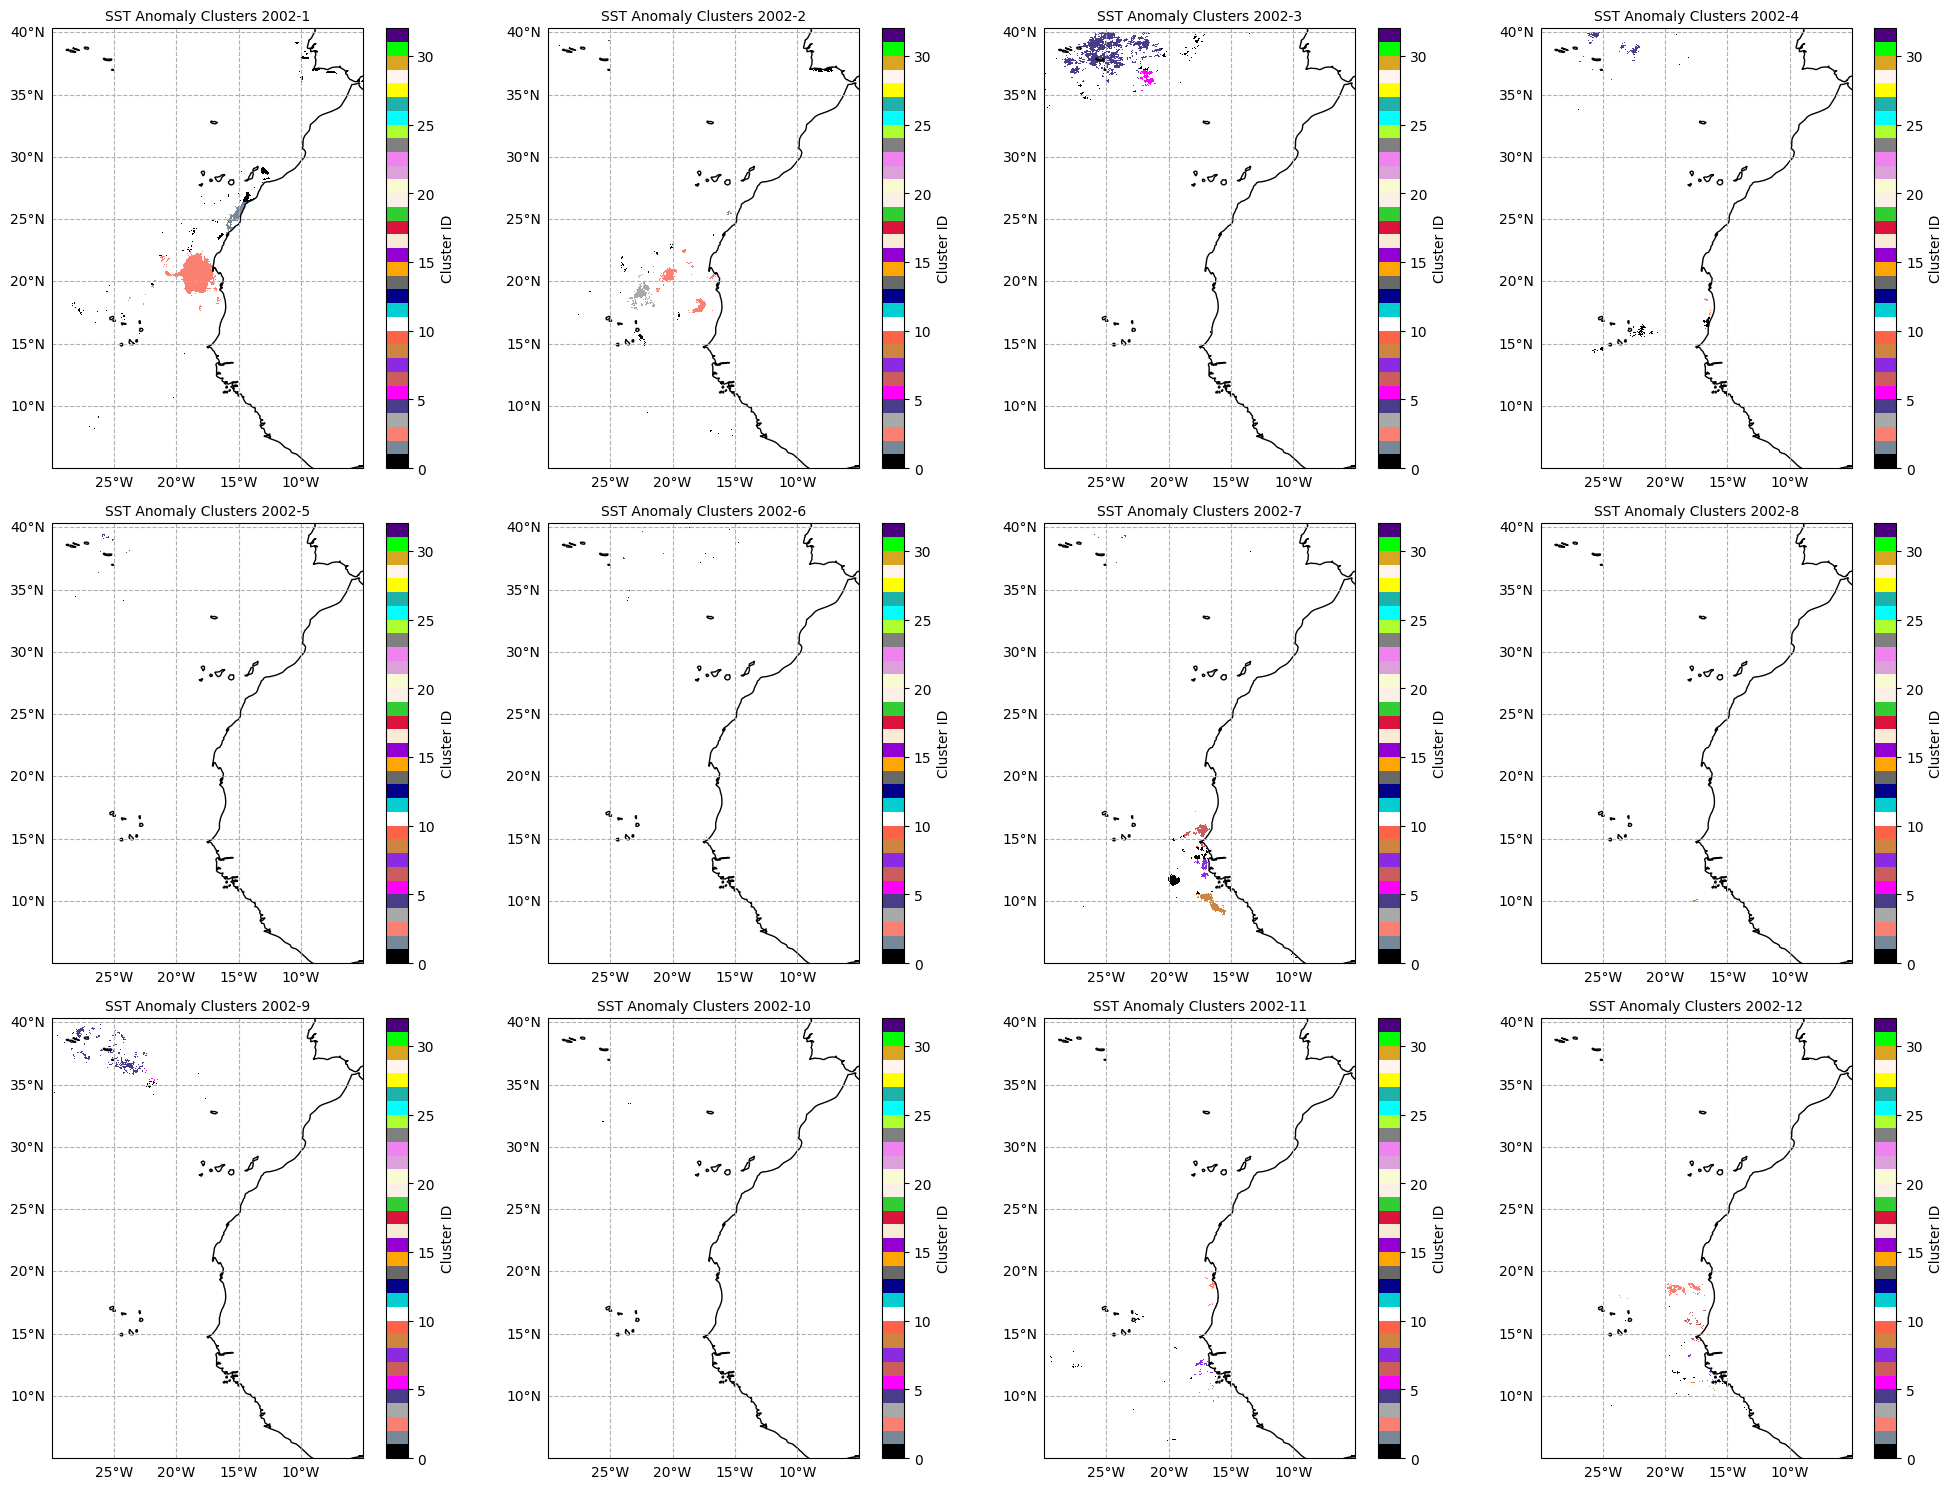

In [6]:
for experiment_result in experiment_results:
    clusters, n_clusters, n_discarded, run_seconds, file_name, experiment_name = experiment_result
    print(f"Experiment name: {experiment_name}")
    print(f"Found: {n_clusters} | Discarded: {n_discarded} | Runtime: {run_seconds:.2f} seconds")
    print(f"File name: {file_name}")
    plot_n_spatial_variable(
        [clusters[i] for i in range(12)],
        ds_sst_anom_neg_full.lat,
        ds_sst_anom_neg_full.lon,
        nrows = 3,
        ncols = 4,
        i_width = 5,
        i_height = 5,
        clim=[0, n_clusters+1], 
        titles = [f'SST Anomaly Clusters {start_date[:4]}-{i+1}' for i in range(12)],
        plot_label = 'Cluster ID',
        cmap = 'labels',
        norm_mode = 'none'
    )